# OpenWebText Pipeline Profiling Analysis

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH SSDs
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 20GB DDR4 (80GB for full dataset)

All plots that are not saved with the `save_fig` function were not used in the paper, but may provide a close-up look on specific values.


### Meta information

* Dataset size: `7.713` GB 
* Amount of `.txt` files: `180662` (`find . -type f | grep .txt | wc -l`)
* Avg. filesize: `0.04269` MB
* Sample sizes (rounded to second decimal):
    * `0500:   21.35 MB` 
    * `1000:   42.69 MB`
    * `2000:   85.39 MB`
    * `4000:  170.78 MB`
    * `8000:  341.56 MB`

## Dataset General Information

In [1]:
full_dataset_textcount = 180662
for sample_size in [500, 1000, 2000, 4000, 8000]:
    print(f"{sample_size} of total: {round(sample_size / full_dataset_textcount * 100, 2)}%")

500 of total: 0.28%
1000 of total: 0.55%
2000 of total: 1.11%
4000 of total: 2.21%
8000 of total: 4.43%


In [2]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')
sys.path.append('../..')
from notebookhelper import show_values_on_bars, save_figure
from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
plotting_palette = "deep"
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context, palette=plotting_palette)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

In [3]:
local_fig_dir = "owt-pipeline"
def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

    
home_path = "../../logs/openwebtext"
path_to_cum_df = f"{home_path}/owt_2021-03-04-18:30:05_cum-df_samples-500-1000-2000-4000-8000-180662_threads-1-2-4-8.csv"
path_to_cum_dstat_df = f"{home_path}/owt_2021-03-04-18:30:05_cum-dstat-df_samples-500-1000-2000-4000-8000-180662_threads-1-2-4-8.csv"
sampling_tag = ""

mat_analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                   , path_to_cum_df = path_to_cum_df)
cum_dstat_df = mat_analysis.to_cum_dstat_df()
cum_df       = mat_analysis.to_cum_df()
summary      = mat_analysis.summary()
strategies   = summary.strategy.unique()
print(strategies)
strategies_renamed = ["unprocessed", "read-files", "extract-content", "bpe", "full"] #"embedding-lookup"]

['0-fully-online' '1-read-files' '2-extract-content'
 '3-byte-pair-encoding' '4-lookup-embedding']


In [4]:
# we remove run 0,1,2,3,4 experiment ueid "a04577" which has the following configuration:
# split_name == '1-read-files'
# sample_count == 8000
# thread_count == 8
# reason: ceph was unusually slow (factor 500x) due to network issues. Experiment is replaced by 5 new entries with expected preprocessing time
cum_df = cum_df.drop(cum_df.query("ueid=='a04577'").index)

In [ ]:
cum_df.query("split_name=='1-read-files' and sample_count==180662")

In [ ]:
cum_dstat_df.head(5)

## 0. Experiment Information

### 0.1 Experiment Count
We define an experiment as profiling a materialization strategy (e.g., `0-fully-online`) with a certain sample count (e.g, `500`).

We replicated **every** experiment **5** times, that means we should have `5 * <mat-strategies> * <thread_count>` experiments for each sample size. The only exception is the full dataset preprocessing, which is ran with `thread_count = 8`.

`norm_thread_experiment_count` should be `5` for all.

Unfortunately the `ueid`s are based on the way the experiments were ran (in the python loop vs. bash loop), so we only count the rows, as each row in the `cum_df` dataframe is a single experiment.

In [ ]:
experiment_count_dict = {
    "sample_count": []
  , "sample_experiment_count": []
  , "thread_count": []
  , "thread_experiment_count": []
  , "norm_thread_experiment_count": []
}

def get_experiment_count(df):
    '''Short helper'''
    return len(df.index)

def add_to_dict(sample_count, sample_experiment_count
              , thread_count, thread_experiment_count, norm_thread_experiment_count):
    '''Short helper'''
    experiment_count_dict["sample_count"] += [sample_count]
    experiment_count_dict["sample_experiment_count"] += [sample_experiment_count]
    experiment_count_dict["thread_count"] += [thread_count]
    experiment_count_dict["thread_experiment_count"] += [thread_experiment_count]
    experiment_count_dict["norm_thread_experiment_count"] += [norm_thread_experiment_count]

for sample_count in cum_df["sample_count"].unique():
    sample_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count}'))
    for thread_count in cum_df.query(f'sample_count=={sample_count}')['thread_count'].unique():
        thread_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count} and thread_count=={thread_count}'))
        norm_thread_experiment_count = thread_experiment_count / len(strategies)
        add_to_dict(sample_count, sample_experiment_count,
                    thread_count, thread_experiment_count, norm_thread_experiment_count)
        
experiment_count_df = pd.DataFrame.from_dict(experiment_count_dict)
experiment_count_df

# 1. Storage Consumption Analysis

## 1.1 Uncompressed dataset storage consumption compared to different strategies

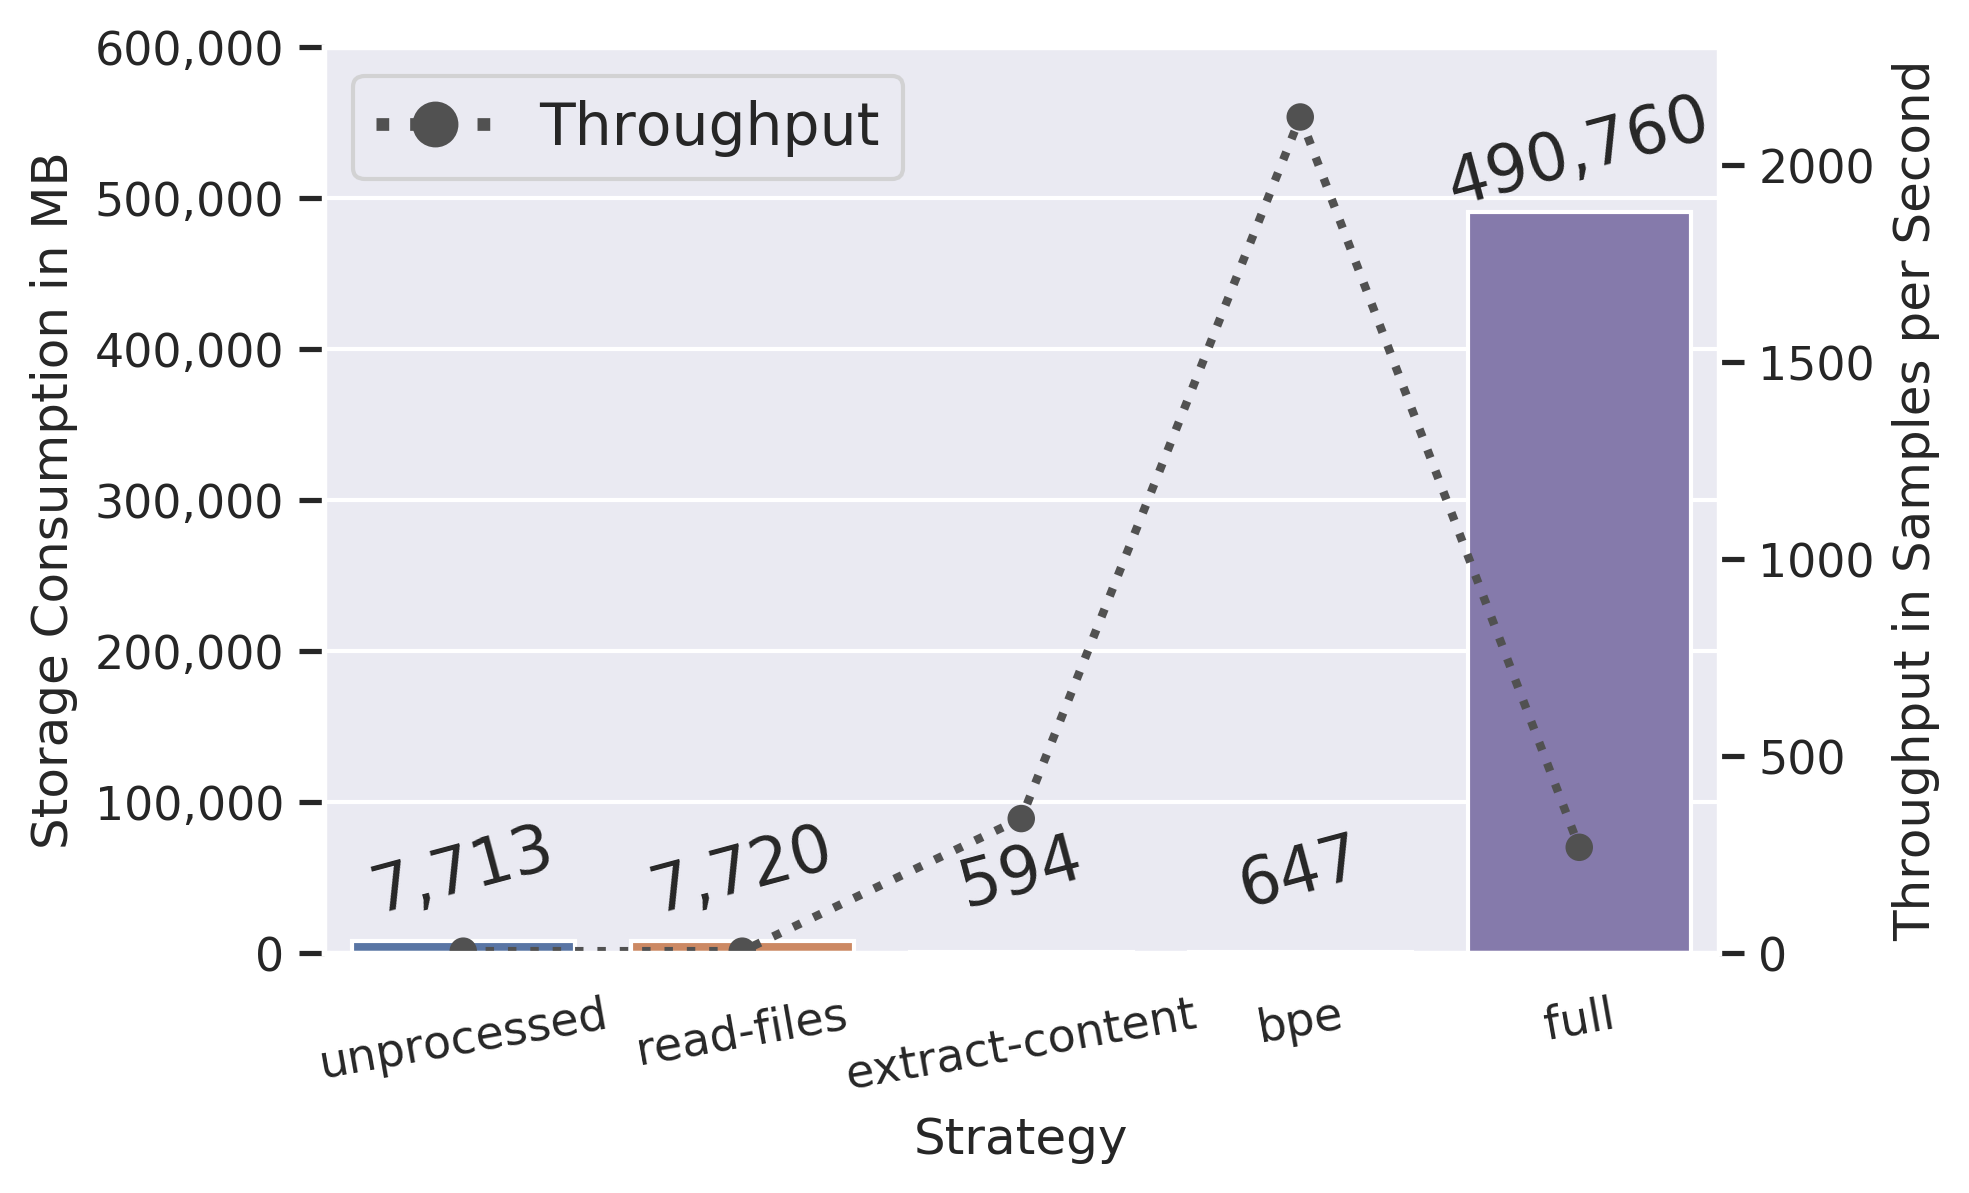

In [10]:
sample_size_mb_dict = {
    "500": 21.35
  , "1000": 42.69
  , "2000": 85.39
  , "4000": 170.78
  , "8000": 341.56
  , "180662": 7713.00
}

storage_consumption_comparison = {
    "storage_consumption": []
  , "sample_count": []
  , "strategy": []
}

def add_to_dict(size, sample_count, label):
    '''Short helper'''
    storage_consumption_comparison["storage_consumption"] += [size]
    storage_consumption_comparison["sample_count"] += [sample_count]
    storage_consumption_comparison["strategy"] += [label]
    
for sample_count in cum_df.sample_count.unique():
    for i, strategy in enumerate(sorted(strategies)):
        shard_sizes_mb = cum_df.query(f"split_name=='{strategy}' and sample_count=={sample_count}")["shard_cum_size_MB"].to_numpy()
        for size_mb in shard_sizes_mb:
            if i == 0: # i.e., unprocessed
                size_mb = sample_size_mb_dict[str(sample_count)]
            add_to_dict(size = size_mb
                      , sample_count = sample_count
                      , label = strategies[i])

storage_df = pd.DataFrame(storage_consumption_comparison)

from matplotlib.lines import Line2D

throughput_color = "#515151"
marker = 'o'
linestyle = ":"

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.set(font_scale=1.3)


## throughput plot
plot2 = sns.pointplot(x="split_name", y="throughput_sps",
                    data=cum_df.query(f"sample_count=={np.max(cum_df.sample_count.unique())}"),
                    ax=ax2, scale=0.75, color=throughput_color, linestyles=linestyle, ci=0.95, marker='o')

plot2.set(ylabel="Throughput in Samples per Second")
plot2.set_xticklabels(
    strategies_renamed
  , rotation=20
)
ax2.grid(False)
legend_elements = [Line2D([0], [0], marker=marker, markersize=10, color=throughput_color, lw=3.05, label='Throughput', linestyle=linestyle)]
ax2.legend(handles=legend_elements, loc="upper left", prop={'size': 14})
plot2.set(ylim=(0, 2300))          


plot = sns.barplot(
        x="strategy",
        y="storage_consumption",
        data=storage_df.query(f"sample_count=={np.max(cum_df.sample_count.unique())}"),
        ax=ax1
    )
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
show_values_on_bars(plot, h_v="v", space=50000, rotation=15)
plot.set(ylabel="Storage Consumption in MB", xlabel="Strategy")
plot.set(ylim=(0, 600000))

# FuncFormatter can be used as a decorator
@ticker.FuncFormatter
def major_formatter(value, pos):
    return re.sub(r'(?<!^)(?=(\d{3})+$)', r',', str(value)[0:-2])

plot.yaxis.set_major_formatter(major_formatter)
#save_fig("storage-consumption")

# 2. Preprocessing Time Anaylsis

## 2.1 Preprocessing time plots

[(0, 2500)]

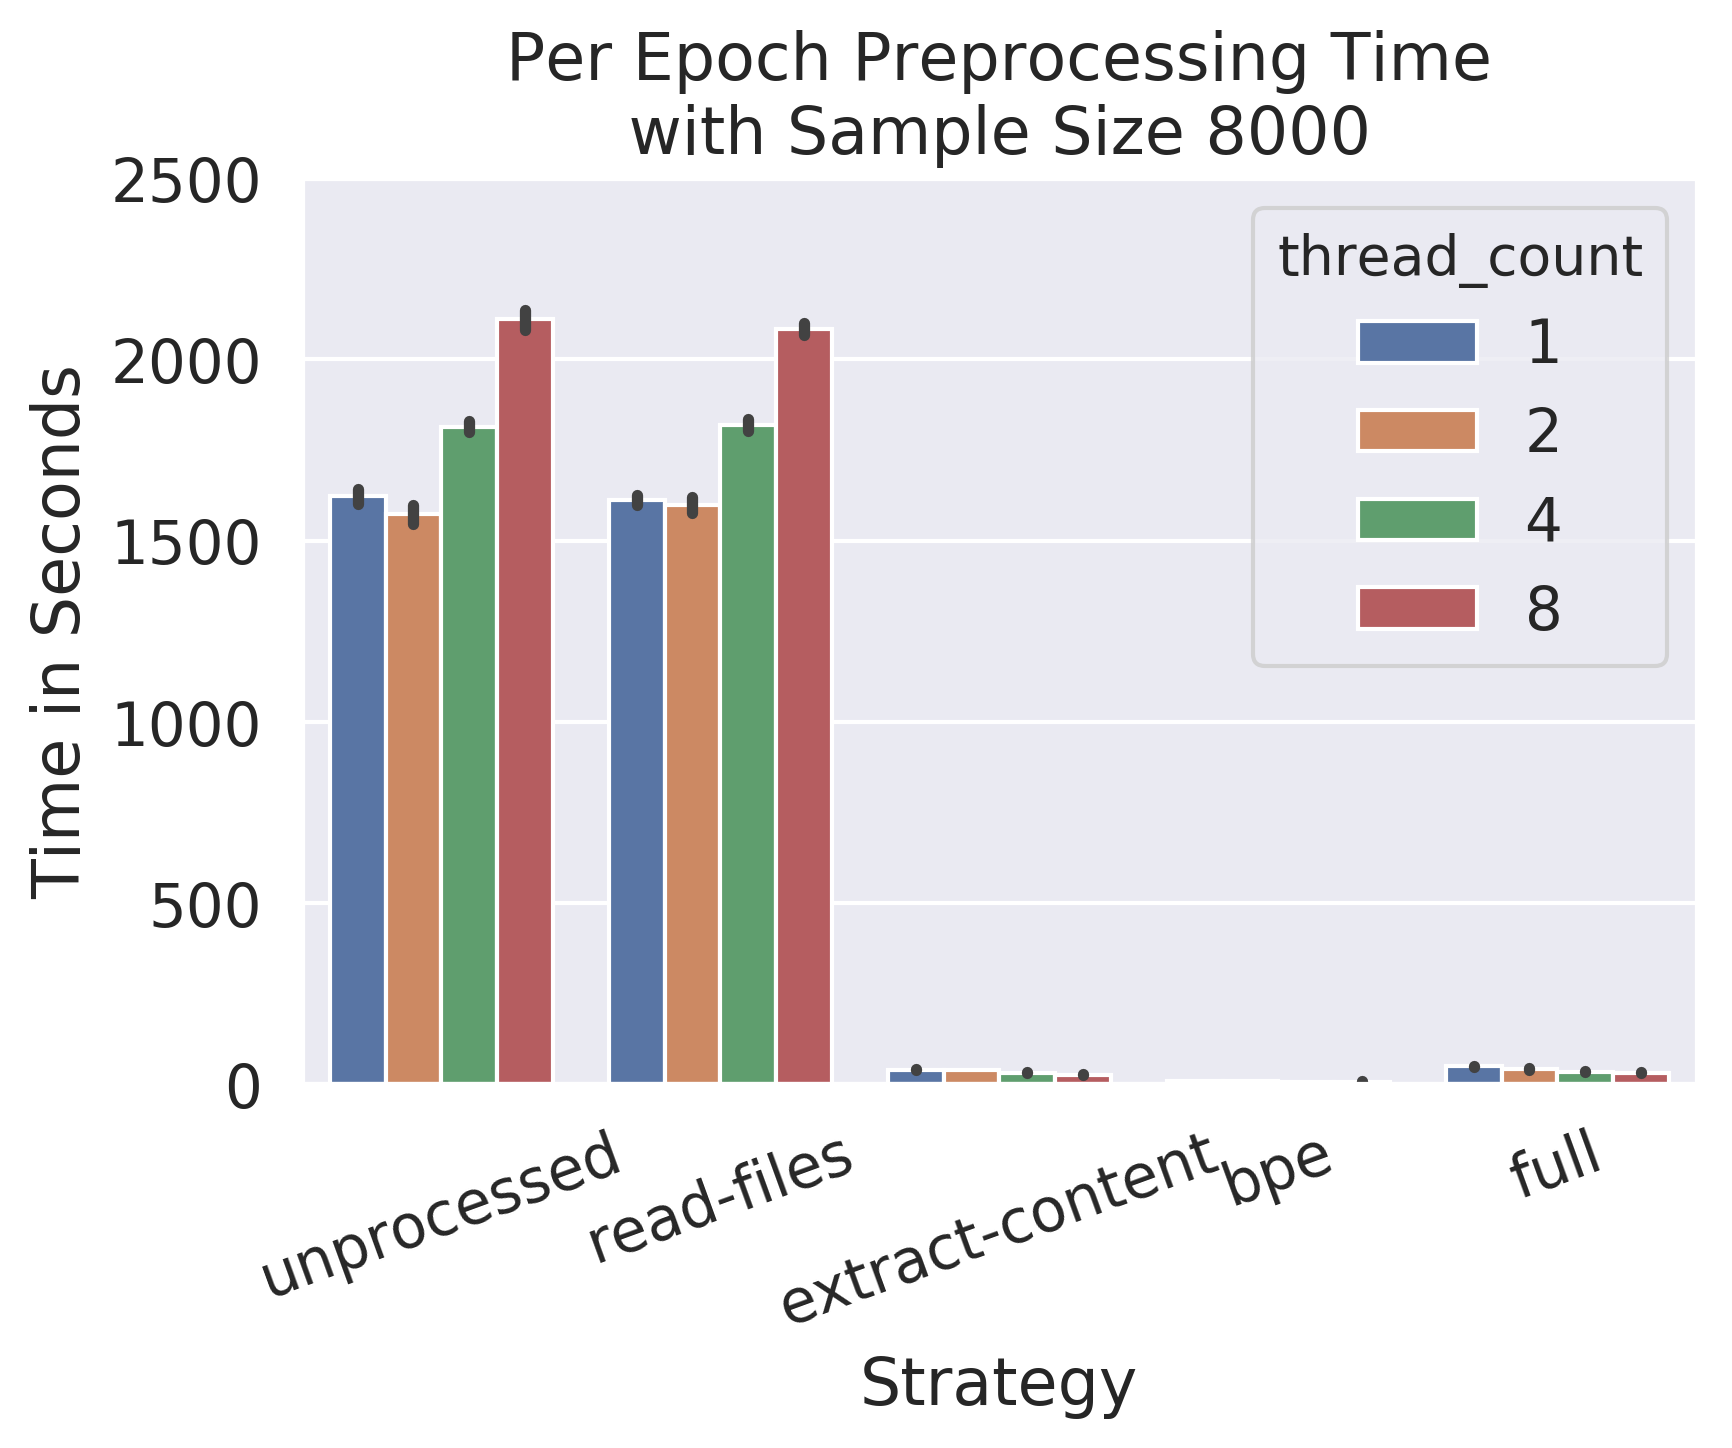

In [10]:
plot = sns.barplot(
    x="split_name",
    y="online_processing_time_s",
    hue="thread_count",
    data=cum_df.query(f"sample_count==8000")
)
plot.set_title(f"Per Epoch Preprocessing Time\n with Sample Size 8000 {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
plot.set(ylim=(0, 2500))

[(0, 2500)]

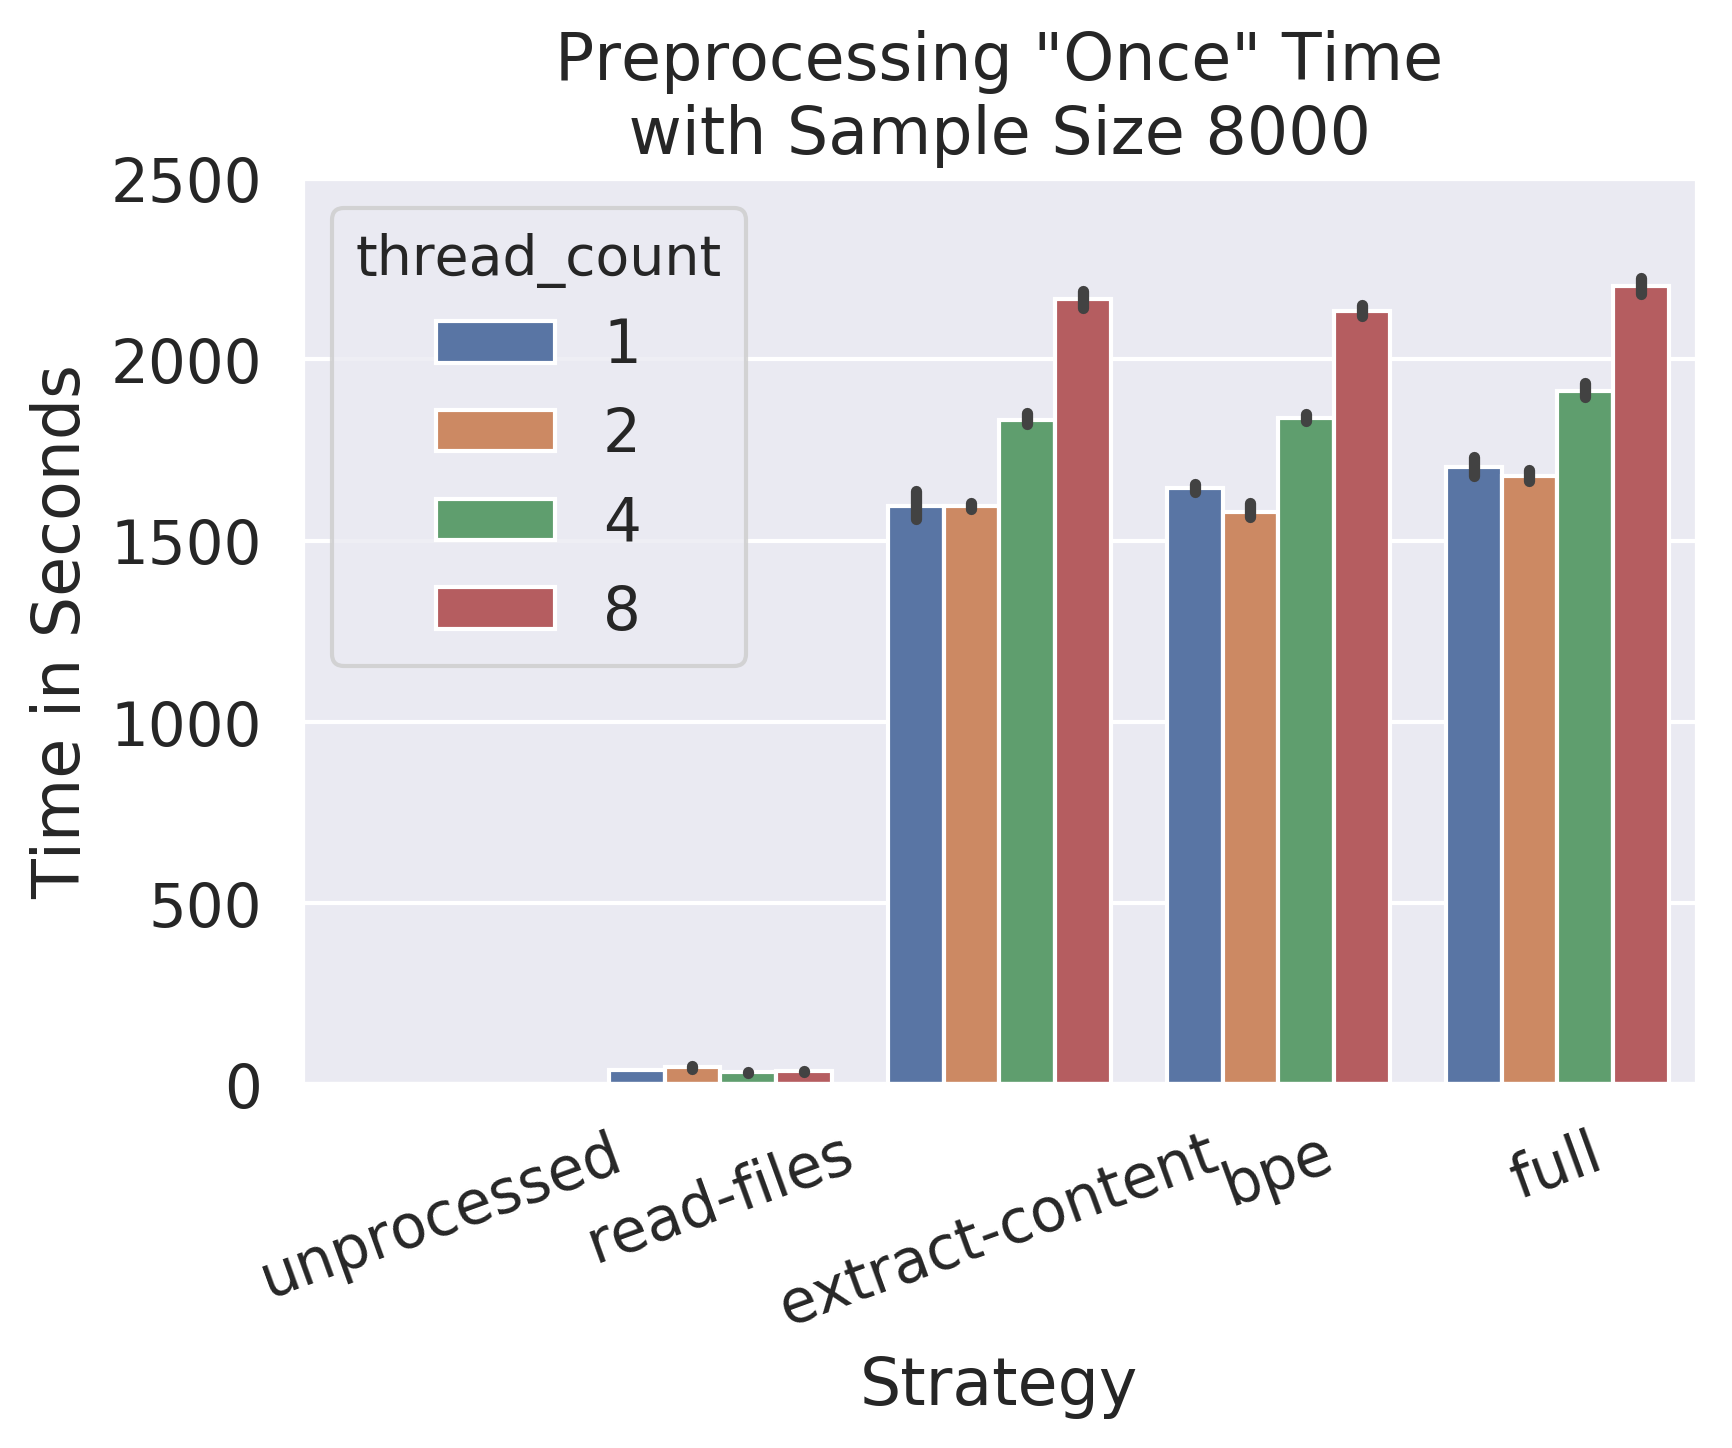

In [11]:
plot = sns.barplot(
    x="split_name",
    y="offline_processing_and_save_time_s",
    hue="thread_count",
    data=cum_df.query(f"sample_count==8000")
)
plot.set_title(f"Preprocessing \"Once\" Time\n with Sample Size 8000 {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
plot.set(ylim=(0, 2500))

## 2.2 Unmarshalling cost for last data representation

[Text(0, 0.5, 'Time in Seconds'), Text(0.5, 0, 'Sample Count')]

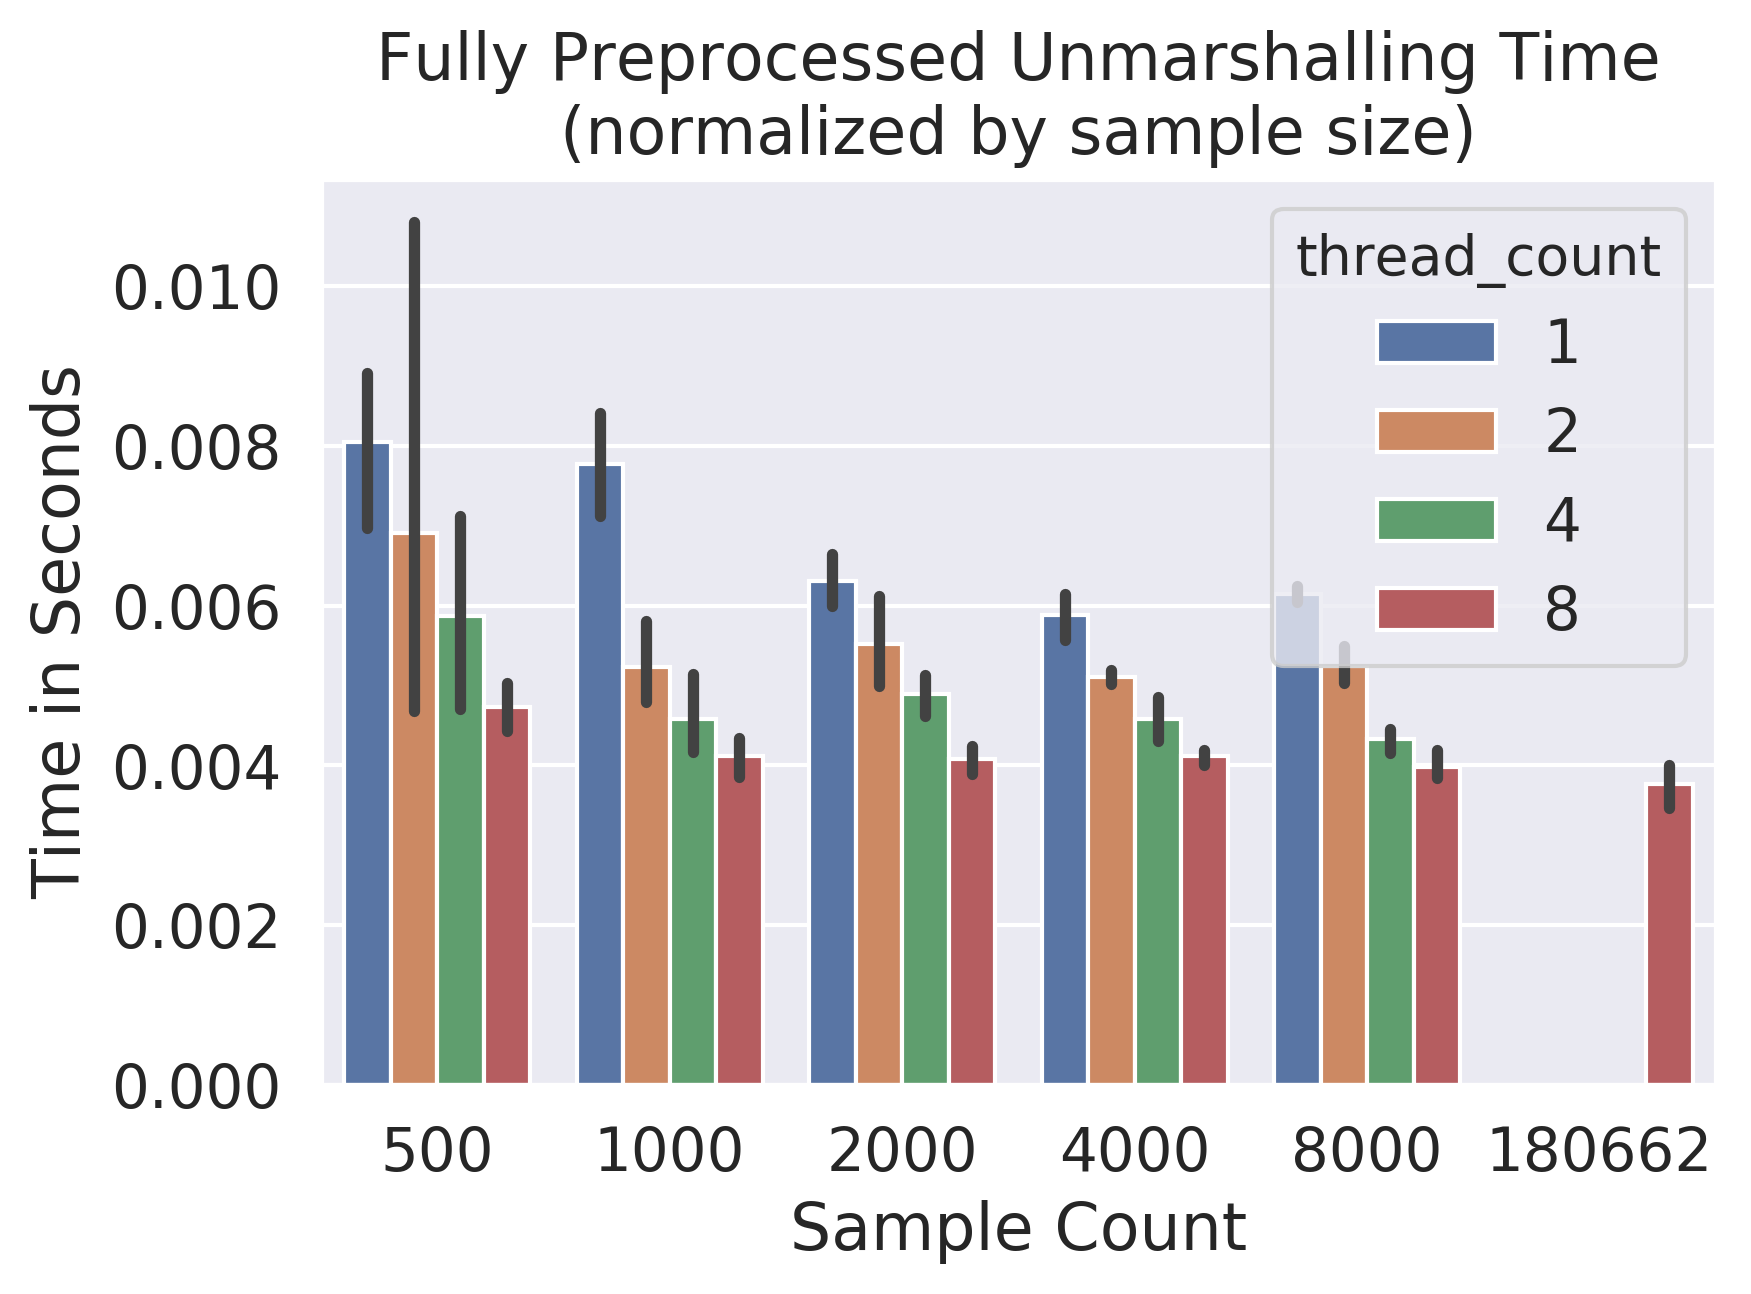

In [12]:
test_df = cum_df.copy(deep=True)
test_df["normalized_online_processing_time_s"] = test_df["online_processing_time_s"] / test_df["sample_count"]

plot = sns.barplot(
    x="sample_count",
    y="normalized_online_processing_time_s",
    hue="thread_count",
    data=test_df.query(f"split_name=='{strategies[-1]}'")
)
plot.set_title(f"Fully Preprocessed Unmarshalling Time\n(normalized by sample size){sampling_tag}")
plot.set(xlabel="Sample Count", ylabel="Time in Seconds")
#plot.set(ylim=(0,1.4))

# 3. Throughput Analysis

## 3.1 Throughput (sample_count = 8000)

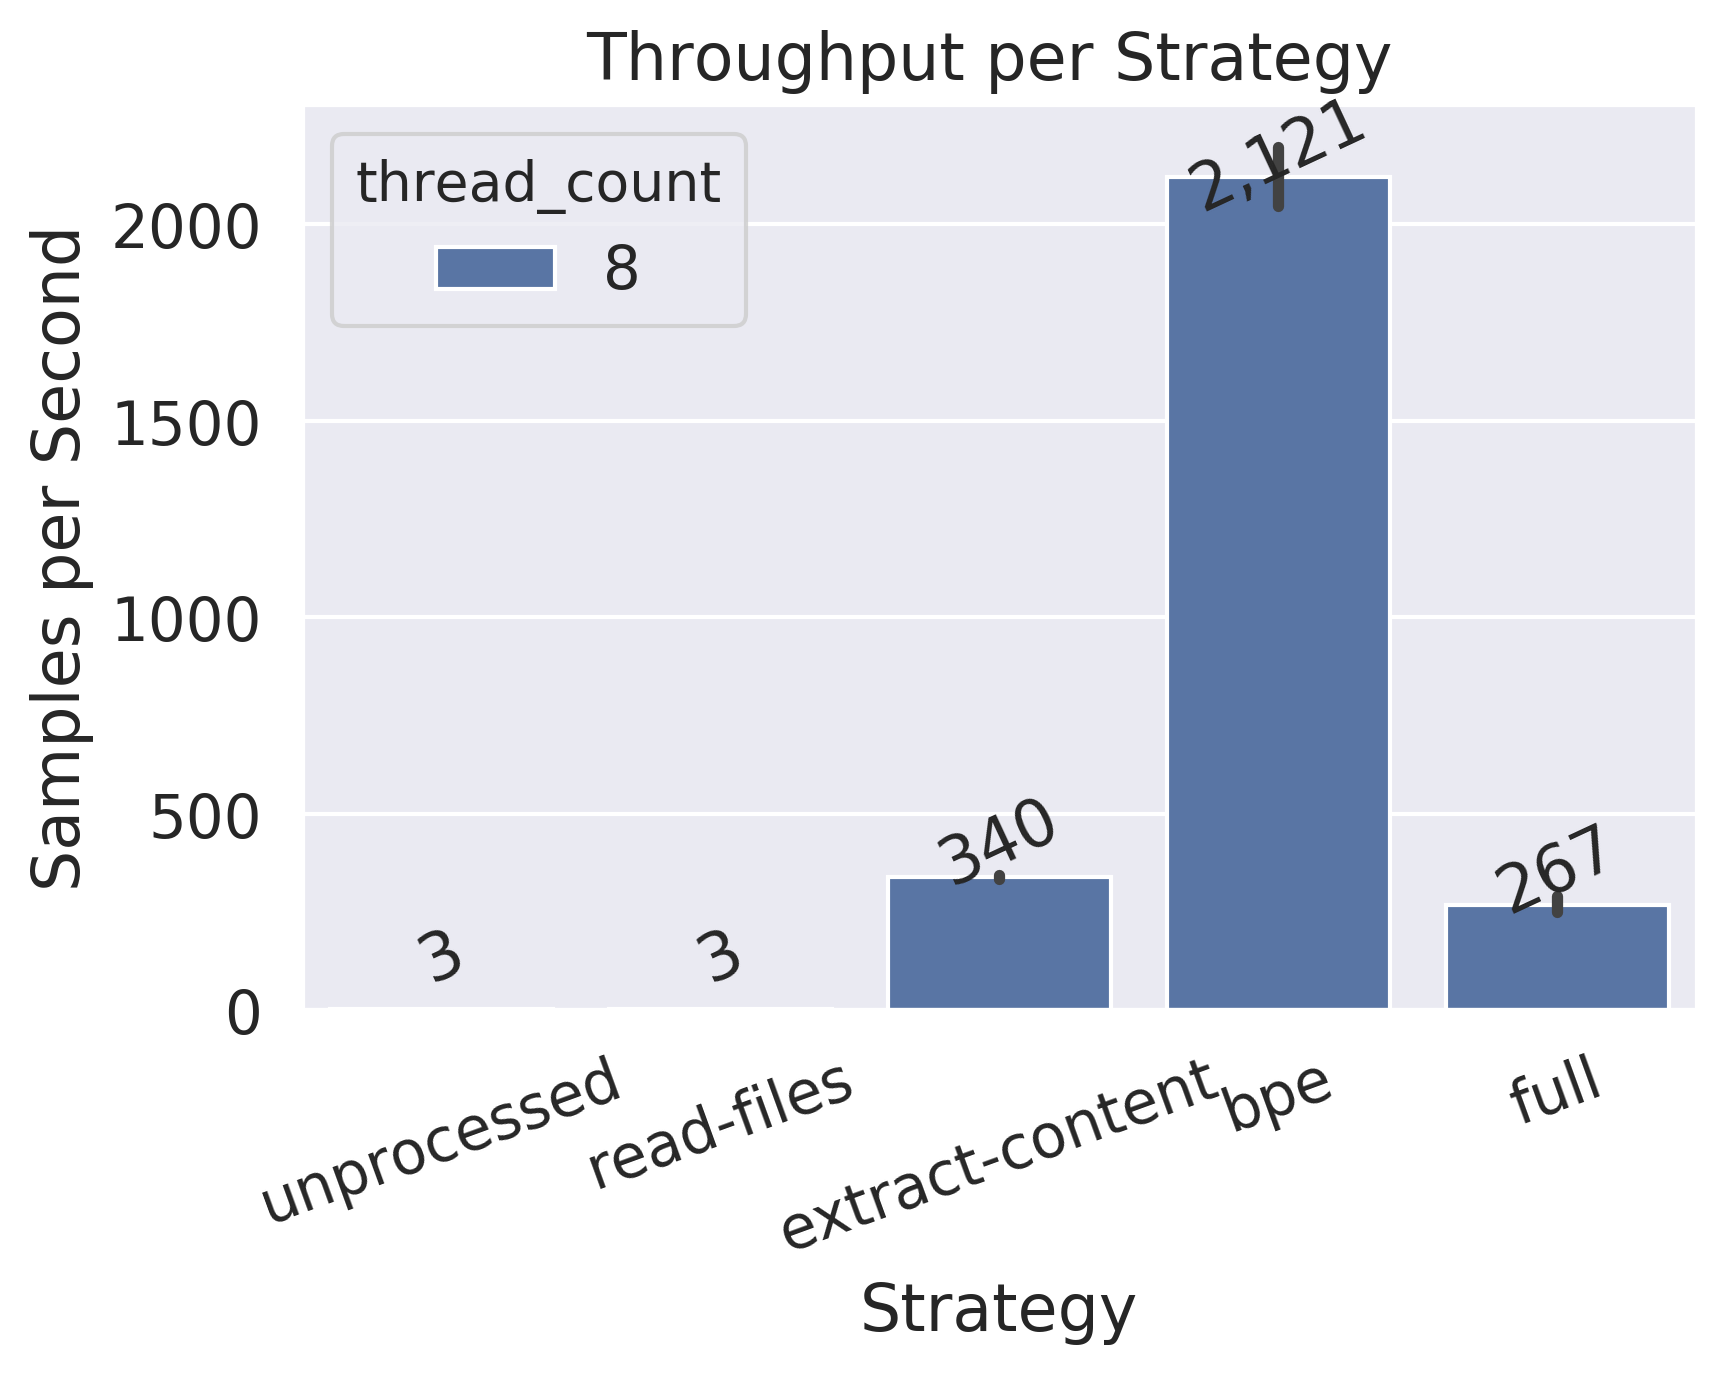

In [12]:
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="thread_count",
    data=cum_df.query(f"sample_count==180662")
)
plot.set_title(f"Throughput per Strategy {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Samples per Second")
#plot.set(ylim=(0, 1200))

#additional_space = [-180, -105, -150, 0, 0] \
#                 + [-50, 0, 0, 0, 0] \
#                 + [60, 0, -80, 0, 0] \
#                 + [0, 0, 0, 0, 100]
show_values_on_bars(plot, space=100)#, additional_space=additional_space)

In [16]:
# First calculation for the introduction - BPE vs Embedding throughput
bpe='3-byte-pair-encoding'
emb='4-lookup-embedding'
bpe_mean_throughput = cum_df.query(f"sample_count==8000 and thread_count==8 and split_name=='{bpe}'")["throughput_sps"].mean()
emb_mean_throughput = cum_df.query(f"sample_count==8000 and thread_count==8 and split_name=='{emb}'")["throughput_sps"].mean()
print(f"BPE strategy throughput (8 threads): {np.round(bpe_mean_throughput,0)} sps")
print(f"EMB strategy throughput (8 threads):  {np.round(emb_mean_throughput,0)} sps")

BPE strategy throughput (8 threads): 1082.0 sps
EMB strategy throughput (8 threads):  252.0 sps


## 3.2 Parallelization capabilities (sample_count = 8000)

In [17]:
cum_8000_df = cum_df.query("sample_count==8000")

par_capability = {
      "threads": []
    , "strategy": []
    , "speedup": []
}

def add_capability(threads, strategy, speedup):
    par_capability["threads"] += [threads]
    par_capability["strategy"] += [strategy]
    par_capability["speedup"] += [speedup]

for strategy in strategies:
    for thread_count in cum_df.thread_count.unique():
        throughputs = cum_8000_df.query(f"thread_count=={thread_count} and split_name=='{strategy}'")["throughput_sps"].to_numpy()
        for throughput in throughputs:
            avg_step_t1_throughput = cum_8000_df.query(f"thread_count=={1} and split_name=='{strategy}'")["throughput_sps"].mean()
            # not using percentages here as I feel its more intuitive, benchmarking crimes is still followed from my understanding
            #if avg_step_t1_throughput < throughput:
            #    rel_increase_factor =  throughput / avg_step_t1_throughput - 1
            #    add_capability(thread_count, strategy, np.round(rel_increase_factor, 2))
            #else:
            #    rel_decrease_factor = 1 - throughput / avg_step_t1_throughput
            #    add_capability(thread_count, strategy, -np.round(rel_decrease_factor, 2))
            ## now using speedup instead of increase/decrease factor
            speedup = throughput / avg_step_t1_throughput
            add_capability(thread_count, strategy, speedup)

capability_df = pd.DataFrame(par_capability)
capability_df

,threads,strategy,speedup
0,1,0-fully-online,1.030099
1,1,0-fully-online,1.004541
2,1,0-fully-online,0.989789
3,1,0-fully-online,0.989983
4,1,0-fully-online,0.985588
5,2,0-fully-online,1.014483
6,2,0-fully-online,1.006612
7,2,0-fully-online,1.065725
8,2,0-fully-online,1.039432
9,2,0-fully-online,1.030154


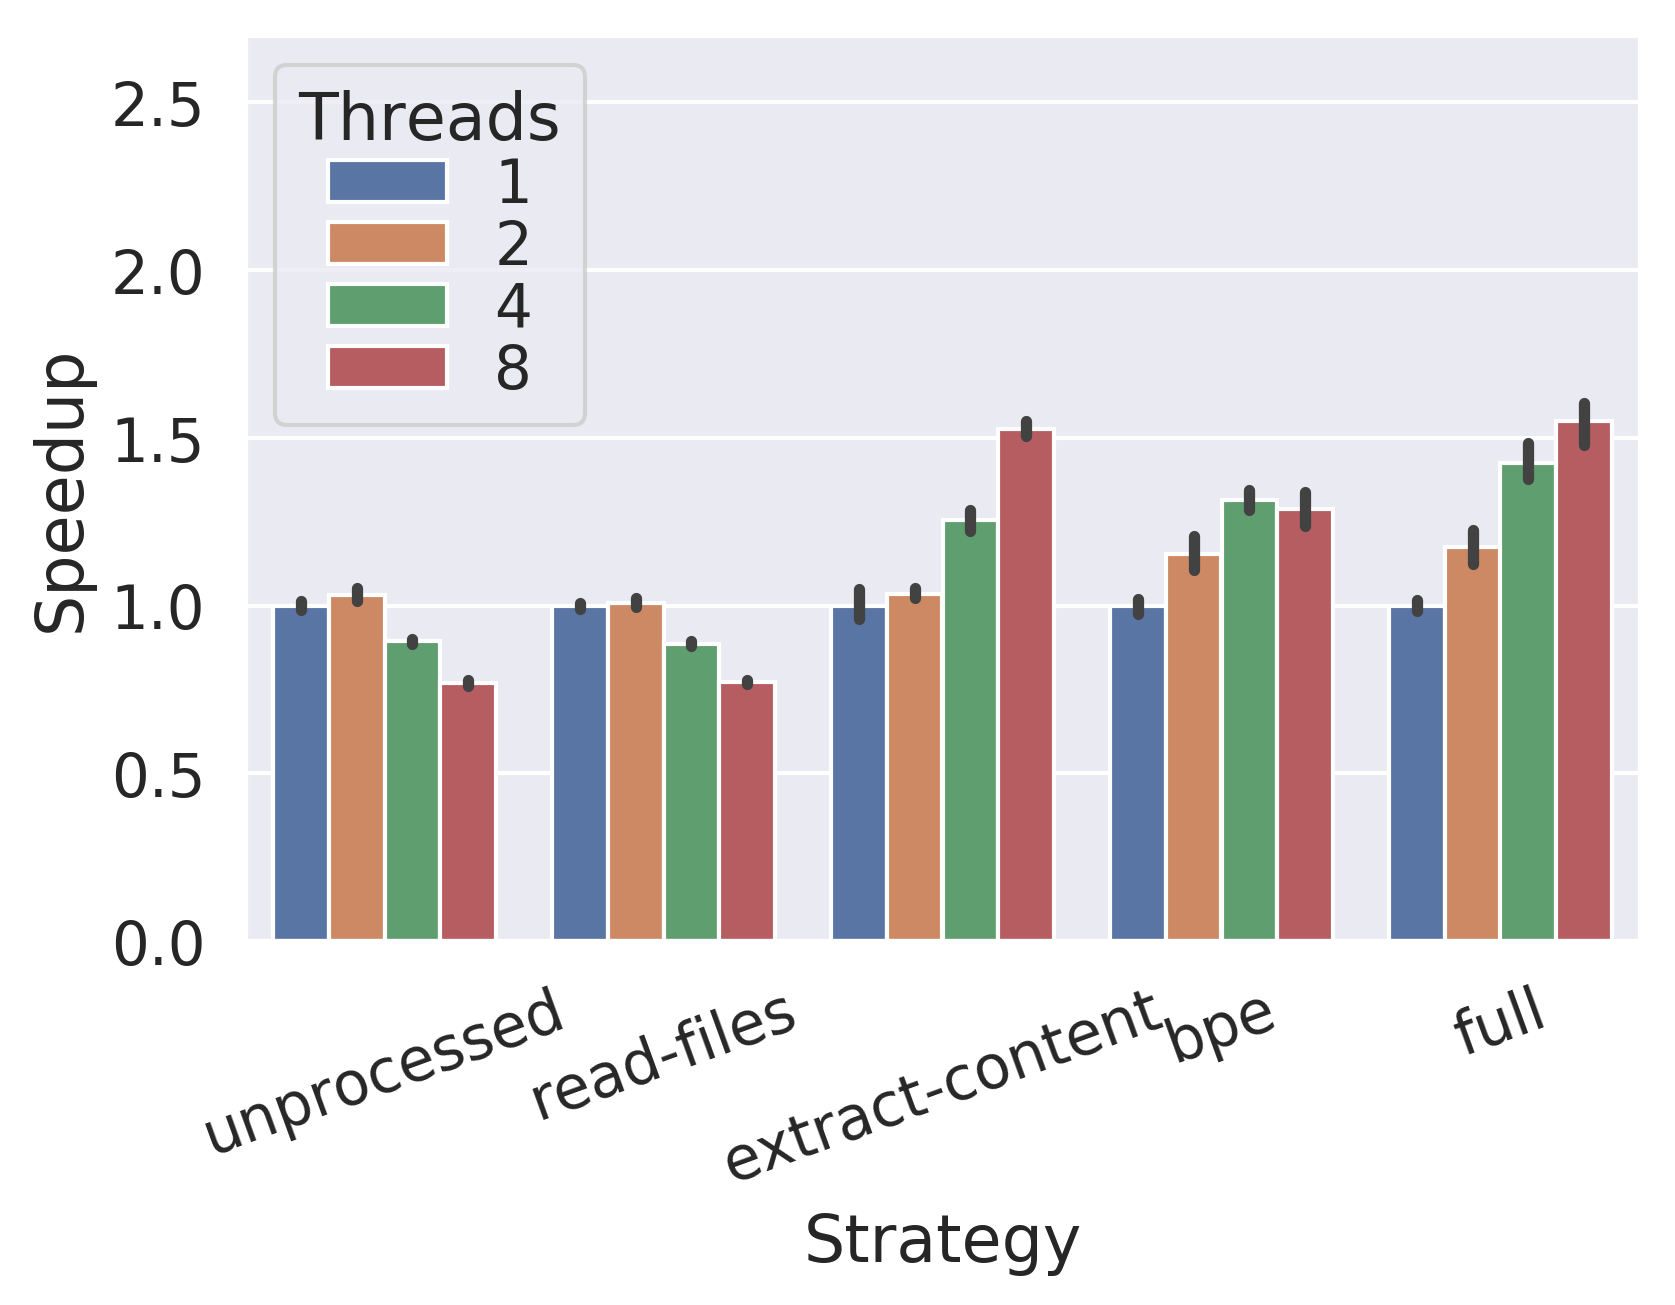

In [18]:
sns.set(font_scale=1.3)
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="threads",
    data=capability_df
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
#plot.set_title(f"Speedup for Each Strategy Compared to\n Average Single Threaded Throughput\n with a Sample Size 8000")
plot.set(xlabel="Strategy", ylabel="Speedup")
plot.set(ylim=(0, 2.7))
plot.legend(title="Threads", ncol=1,labelspacing=0.05)
save_fig("speedup")

## 4. Extrapolation Capabilities

In [19]:
# calculate the per sample processing time for both offline and online processing
cum_df["per_sample_online_processing_time_s"] = cum_df["online_processing_time_s"] / cum_df["sample_count"]
cum_df["per_sample_offline_processing_and_save_time_s"] = cum_df["offline_processing_and_save_time_s"] / cum_df["sample_count"]
# calculate the total processing time for each sample count
cum_df["total_processing_time_s"] = cum_df["online_processing_time_s"] + cum_df["offline_processing_and_save_time_s"]
# extrapolate based on the full count of images
cum_df["full_dataset_online_processing_time_s"] = cum_df["per_sample_online_processing_time_s"] * full_dataset_textcount
cum_df["full_dataset_offline_processing_and_save_time_s"] = cum_df["per_sample_offline_processing_and_save_time_s"] * full_dataset_textcount
cum_df["full_dataset_offline_processing_and_save_time_m"] = cum_df["full_dataset_offline_processing_and_save_time_s"] / 60
cum_df["full_dataset_offline_processing_and_save_time_h"] = cum_df["full_dataset_offline_processing_and_save_time_m"] / 60

# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df["full_dataset_processing_time_s"] = cum_df["full_dataset_online_processing_time_s"] + cum_df["full_dataset_offline_processing_and_save_time_s"]
cum_df["full_dataset_processing_time_m"] = cum_df["full_dataset_processing_time_s"] / 60 
cum_df["full_dataset_processing_time_h"] = cum_df["full_dataset_processing_time_m"] / 60 

cum_df_mod = cum_df.copy(deep=True)
cum_df_mod.loc[cum_df_mod.sample_count == 180662, 'sample_count'] = '181K (full)'
order_dict = { 500: 10, 1000: 11, 2000: 12, 4000: 13, 8000: 14, '181K (full)': 15}
strategy_order_dict = dict(list(enumerate(strategies)))
strategy_order_dict = dict({(y, x) for x, y in strategy_order_dict.items()})
order_dict.update(strategy_order_dict)
cum_df_mod = cum_df_mod.sort_values(by=['split_name', 'sample_count'], key=lambda x: x.map(order_dict))
cum_df_mod

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,...,per_sample_online_processing_time_s,per_sample_offline_processing_and_save_time_s,total_processing_time_s,full_dataset_online_processing_time_s,full_dataset_offline_processing_and_save_time_s,full_dataset_offline_processing_and_save_time_m,full_dataset_offline_processing_and_save_time_h,full_dataset_processing_time_s,full_dataset_processing_time_m,full_dataset_processing_time_h
0,0.000000,1,1,0.000000,500,101.738001,4.914584,0,5,646d32,...,0.203476,0.000000,101.738001,36760.381426,0.000000,0.000000,0.000000,36760.381426,612.673024,10.211217
1,0.000000,1,1,0.000000,500,98.806886,5.060376,1,5,646d32,...,0.197614,0.000000,98.806886,35701.299176,0.000000,0.000000,0.000000,35701.299176,595.021653,9.917028
2,0.000000,1,1,0.000000,500,114.380180,4.371387,2,5,646d32,...,0.228760,0.000000,114.380180,41328.304202,0.000000,0.000000,0.000000,41328.304202,688.805070,11.480085
3,0.000000,1,1,0.000000,500,96.967742,5.156354,3,5,646d32,...,0.193935,0.000000,96.967742,35036.772398,0.000000,0.000000,0.000000,35036.772398,583.946207,9.732437
4,0.000000,1,1,0.000000,500,121.808741,4.104796,4,5,646d32,...,0.243617,0.000000,121.808741,44012.421567,0.000000,0.000000,0.000000,44012.421567,733.540359,12.225673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,49724.056025,8,8,490749.022168,181K (full),579.887076,311.546864,0,1,9ddcbd,...,0.003210,0.275233,50303.943101,579.887076,49724.056025,828.734267,13.812238,50303.943101,838.399052,13.973318
509,50171.035459,8,8,490775.628772,181K (full),729.990303,247.485479,0,1,8f0088,...,0.004041,0.277707,50901.025762,729.990303,50171.035459,836.183924,13.936399,50901.025762,848.350429,14.139174
514,50153.477289,8,8,490762.732524,181K (full),666.960373,270.873664,0,1,241a6d,...,0.003692,0.277609,50820.437663,666.960373,50153.477289,835.891288,13.931521,50820.437663,847.007294,14.116788
519,51172.705323,8,8,490759.657439,181K (full),697.414940,259.045211,0,1,33420a,...,0.003860,0.283251,51870.120263,697.414940,51172.705323,852.878422,14.214640,51870.120263,864.502004,14.408367


In [20]:
step_3 = '3-byte-pair-encoding'
step_4 = '4-lookup-embedding'
mean_3_step_throughput = cum_df_mod.query(f"sample_count=='181K (full)' and split_name=='{step_3}'")["throughput_sps"].mean()
mean_4_step_throughput = cum_df_mod.query(f"sample_count=='181K (full)' and split_name=='{step_4}'")["throughput_sps"].mean()
difference_in_percent = (mean_3_step_throughput-mean_4_step_throughput) / mean_3_step_throughput * 100
print(f"Degradation\n from: {mean_3_step_throughput}\n to:    {mean_4_step_throughput}\n equals: {difference_in_percent}%")

Degradation
 from: 2121.461410412784
 to:    267.4859186767323
 equals: 87.39143133295617%


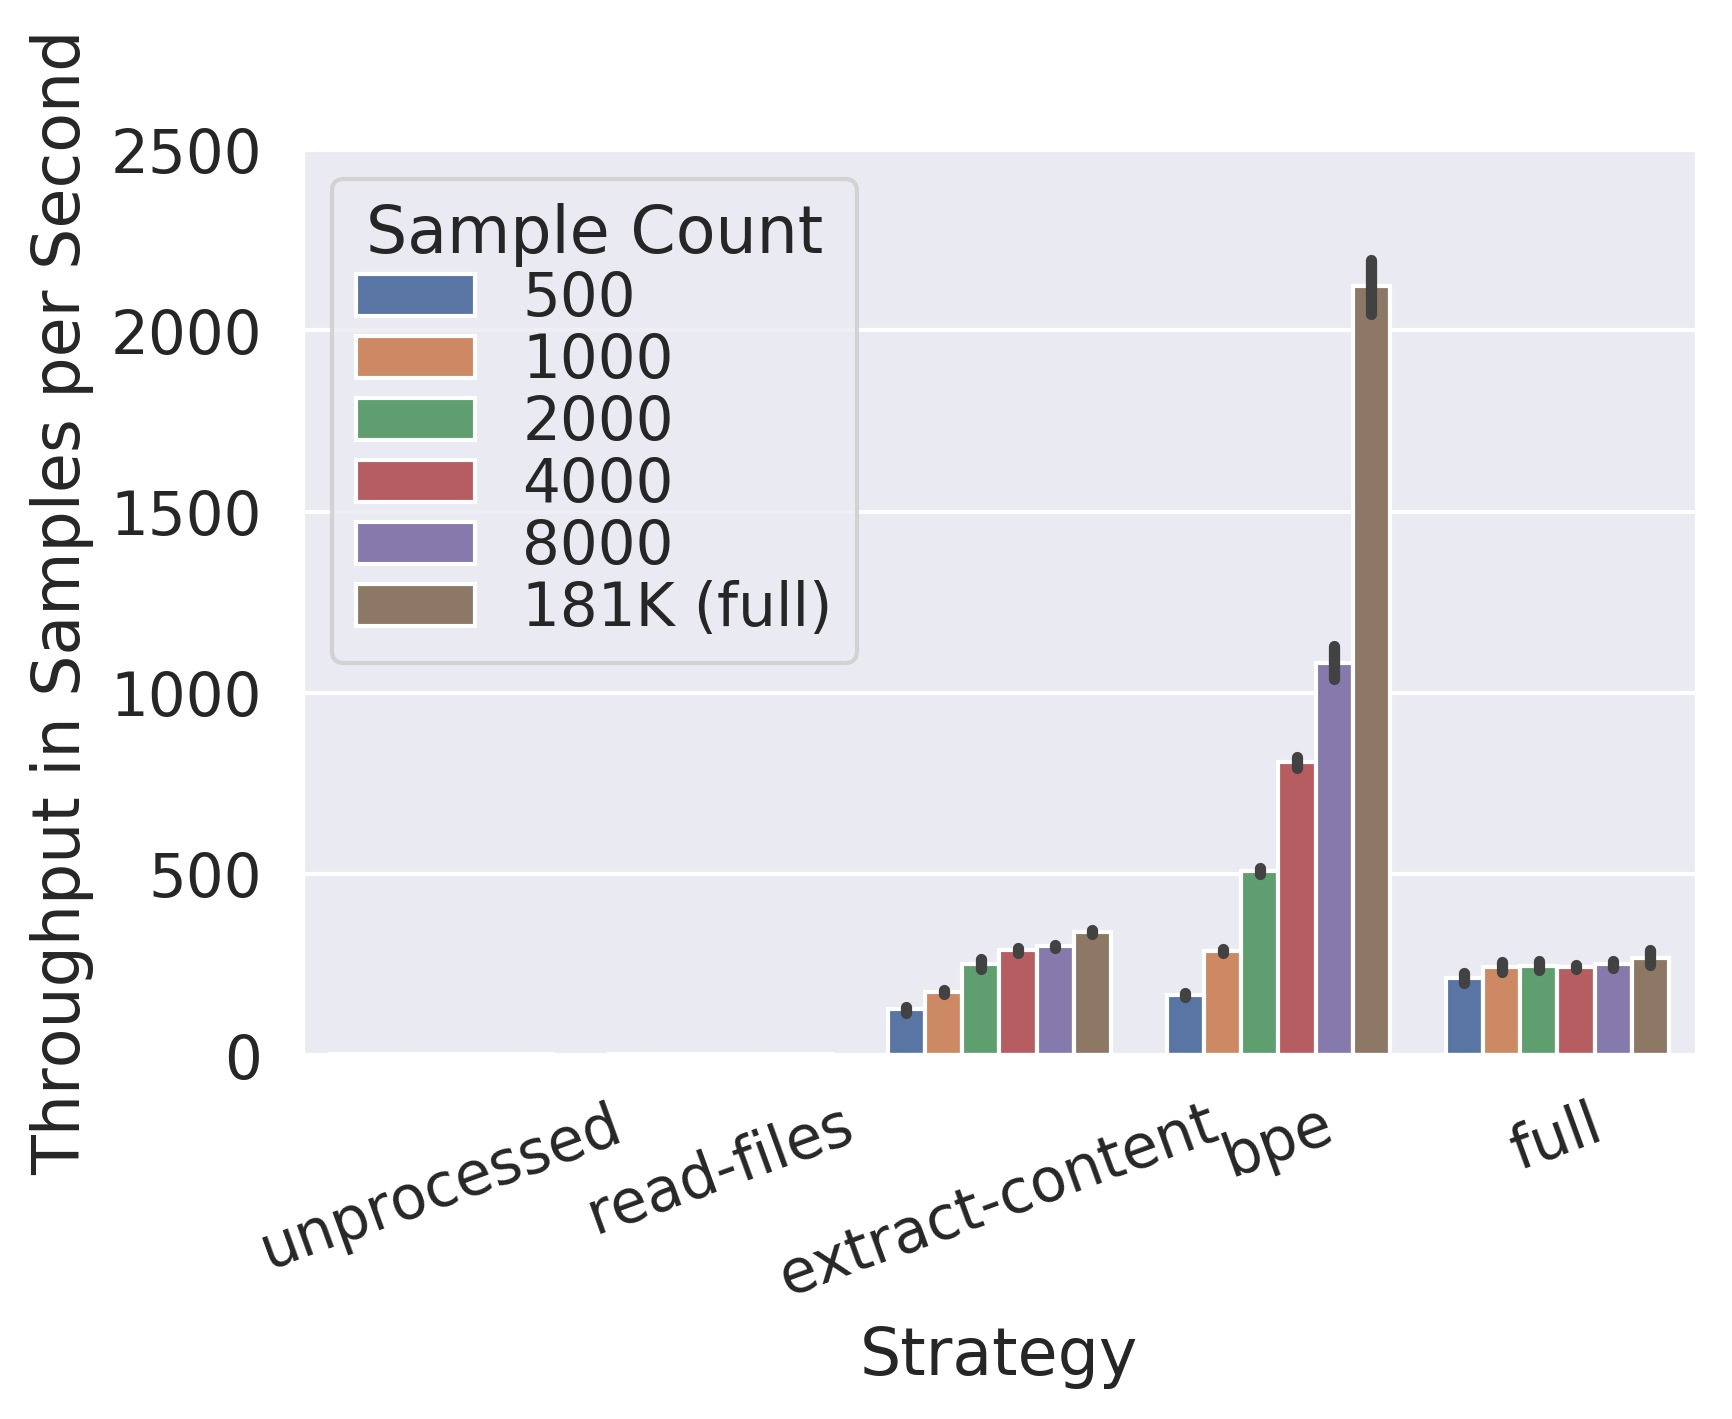

In [21]:
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8")
)
#plot.set_title(f"Throughput per Strategy with 8 Threads\n{sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Second")
plot.set(ylim=(0, 2500))
plot.legend(title="Sample Count", ncol=1,labelspacing=0.05)
save_fig("throughput")

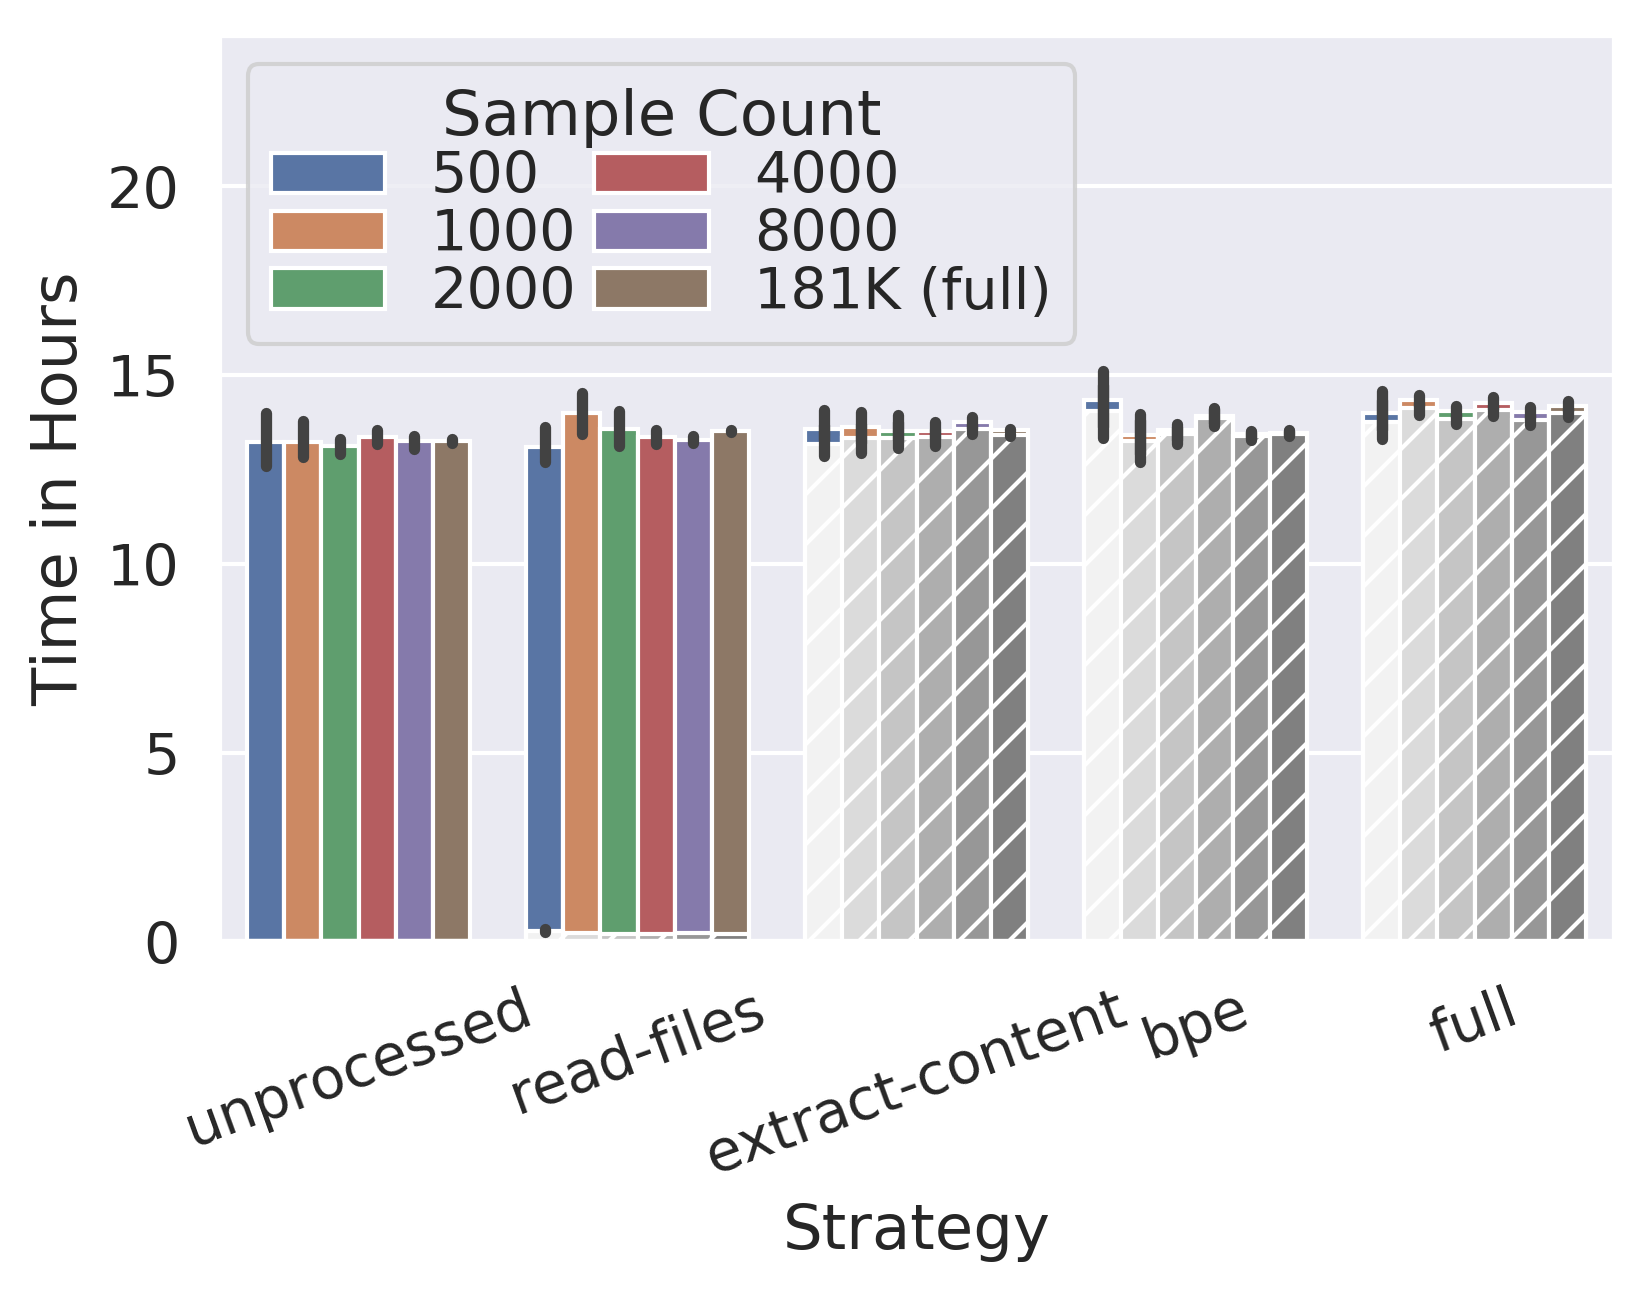

In [22]:
sns.set(font_scale=1.25)
plot = sns.barplot(
    x="split_name",
    y="full_dataset_processing_time_h",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8")
)
plot = sns.barplot(
    x="split_name",
    y="full_dataset_offline_processing_and_save_time_h",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8"),
    color="grey"
)

sample_counts = len([500, 1000, 2000, 4000, 8000, '181K (full)']) 
bars_to_skip = sample_counts * len(strategies)
hatches = ['//'] * bars_to_skip
for i,bar in enumerate(plot.patches[bars_to_skip:]):
    bar.set_hatch(hatches[i])

#plot.set_title(f"Per Epoch Per Sample Processing Time\n for Each Strategy with 8 Threads{sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Hours")
plot.set(ylim=(0, 24))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[:sample_counts], title="Sample Count", loc="upper left", ncol=2, labelspacing=0.05, columnspacing=0.3)
save_fig("full-processing-time")

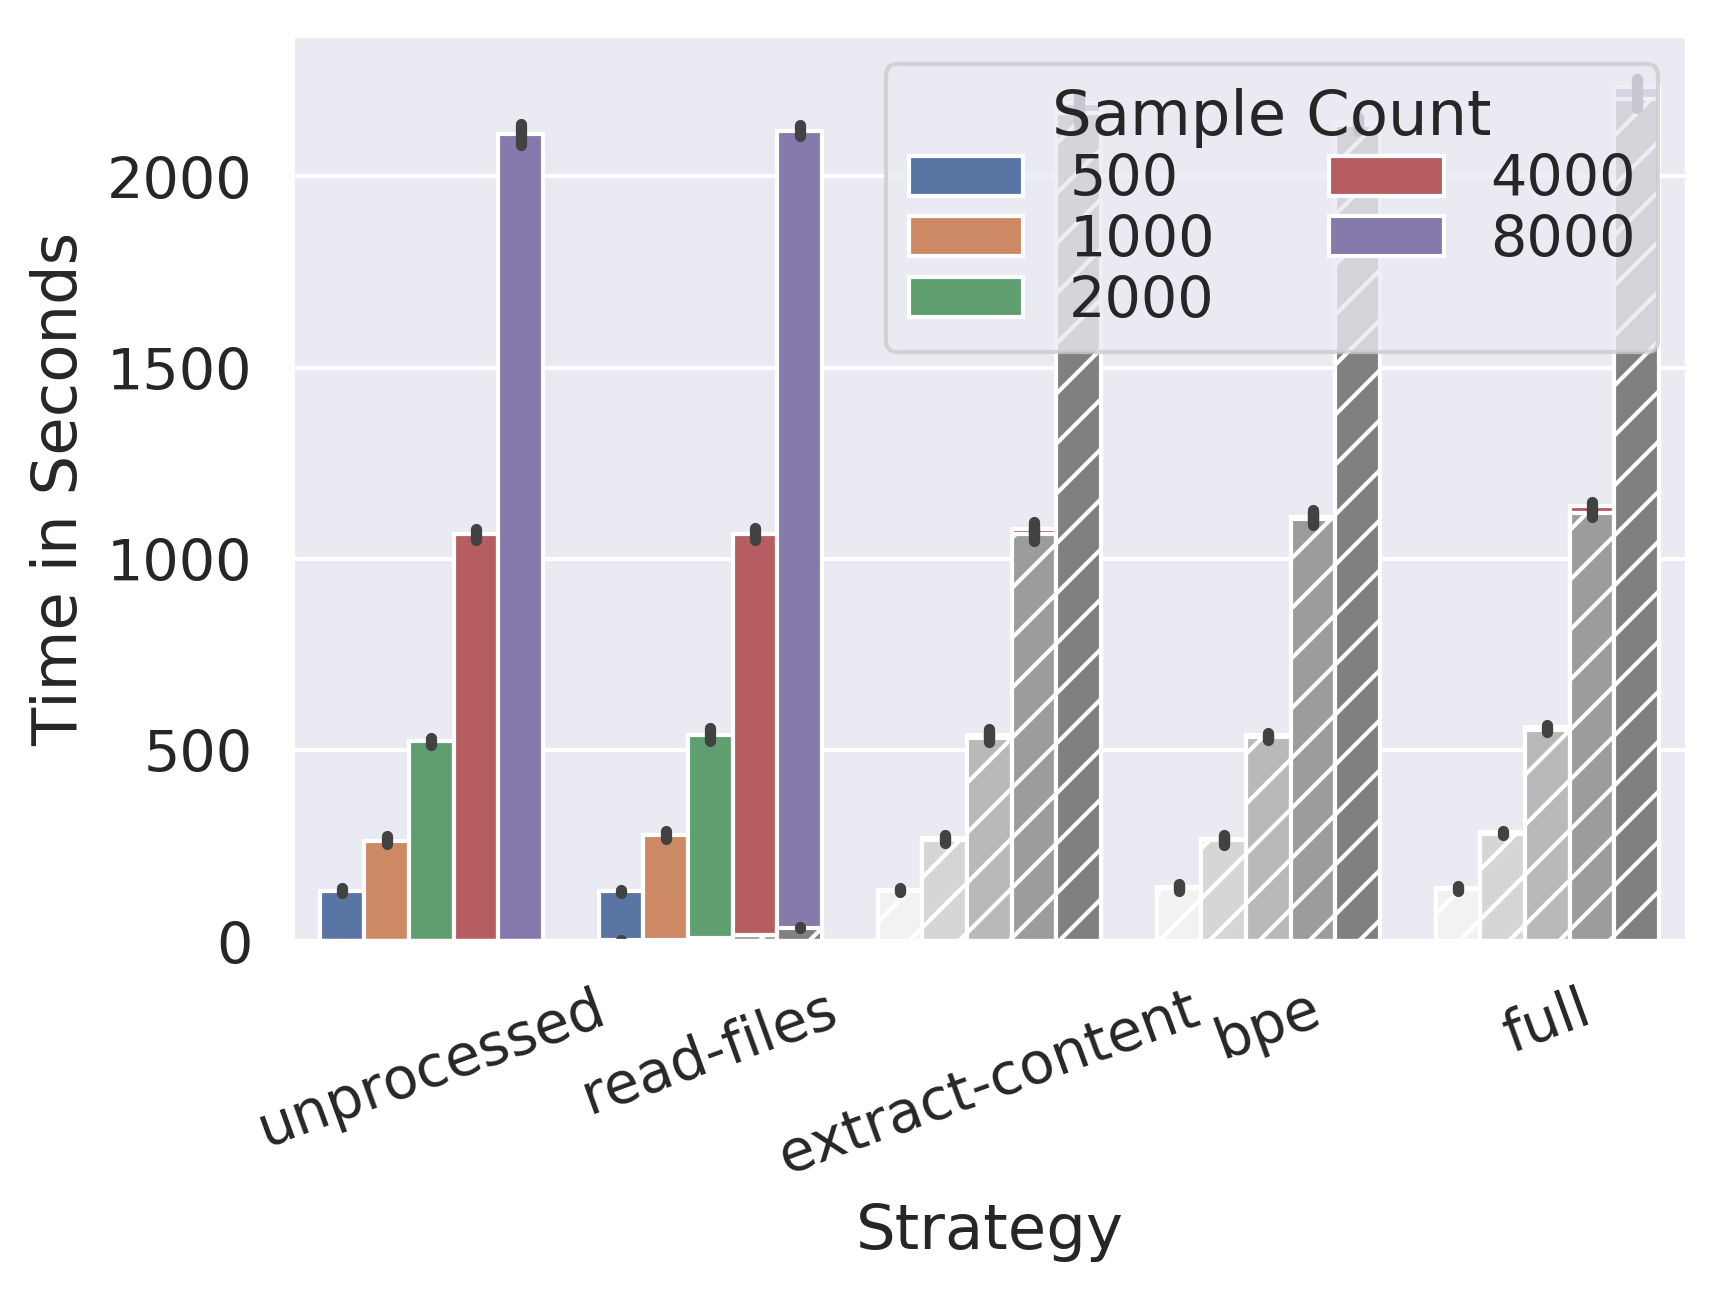

In [23]:
cum_df_preprocessing_time_comparison = cum_df_mod.query(f"thread_count==8 and sample_count!='181K (full)'")

plot = sns.barplot(
    x="split_name",
    y="total_processing_time_s",
    hue="sample_count",
    data=cum_df_preprocessing_time_comparison
)
plot = sns.barplot(
    x="split_name",
    y="offline_processing_and_save_time_s",
    hue="sample_count",
    data=cum_df_preprocessing_time_comparison,
    color="grey"
)

sample_counts = len([500, 1000, 2000, 4000, 8000])
bars_to_skip = sample_counts * len(strategies)
hatches = ['//'] * bars_to_skip
for i,bar in enumerate(plot.patches[bars_to_skip:]):
    bar.set_hatch(hatches[i])

#plot.set_title(f"Per Epoch Per Sample Processing Time\n for Each Strategy with 8 Threads{sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
#plot.set(ylim=(0, 27))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[:sample_counts], title="Sample Count", loc="upper right", ncol=2, labelspacing=0.10)
save_fig("processing-time-per-sample-count")

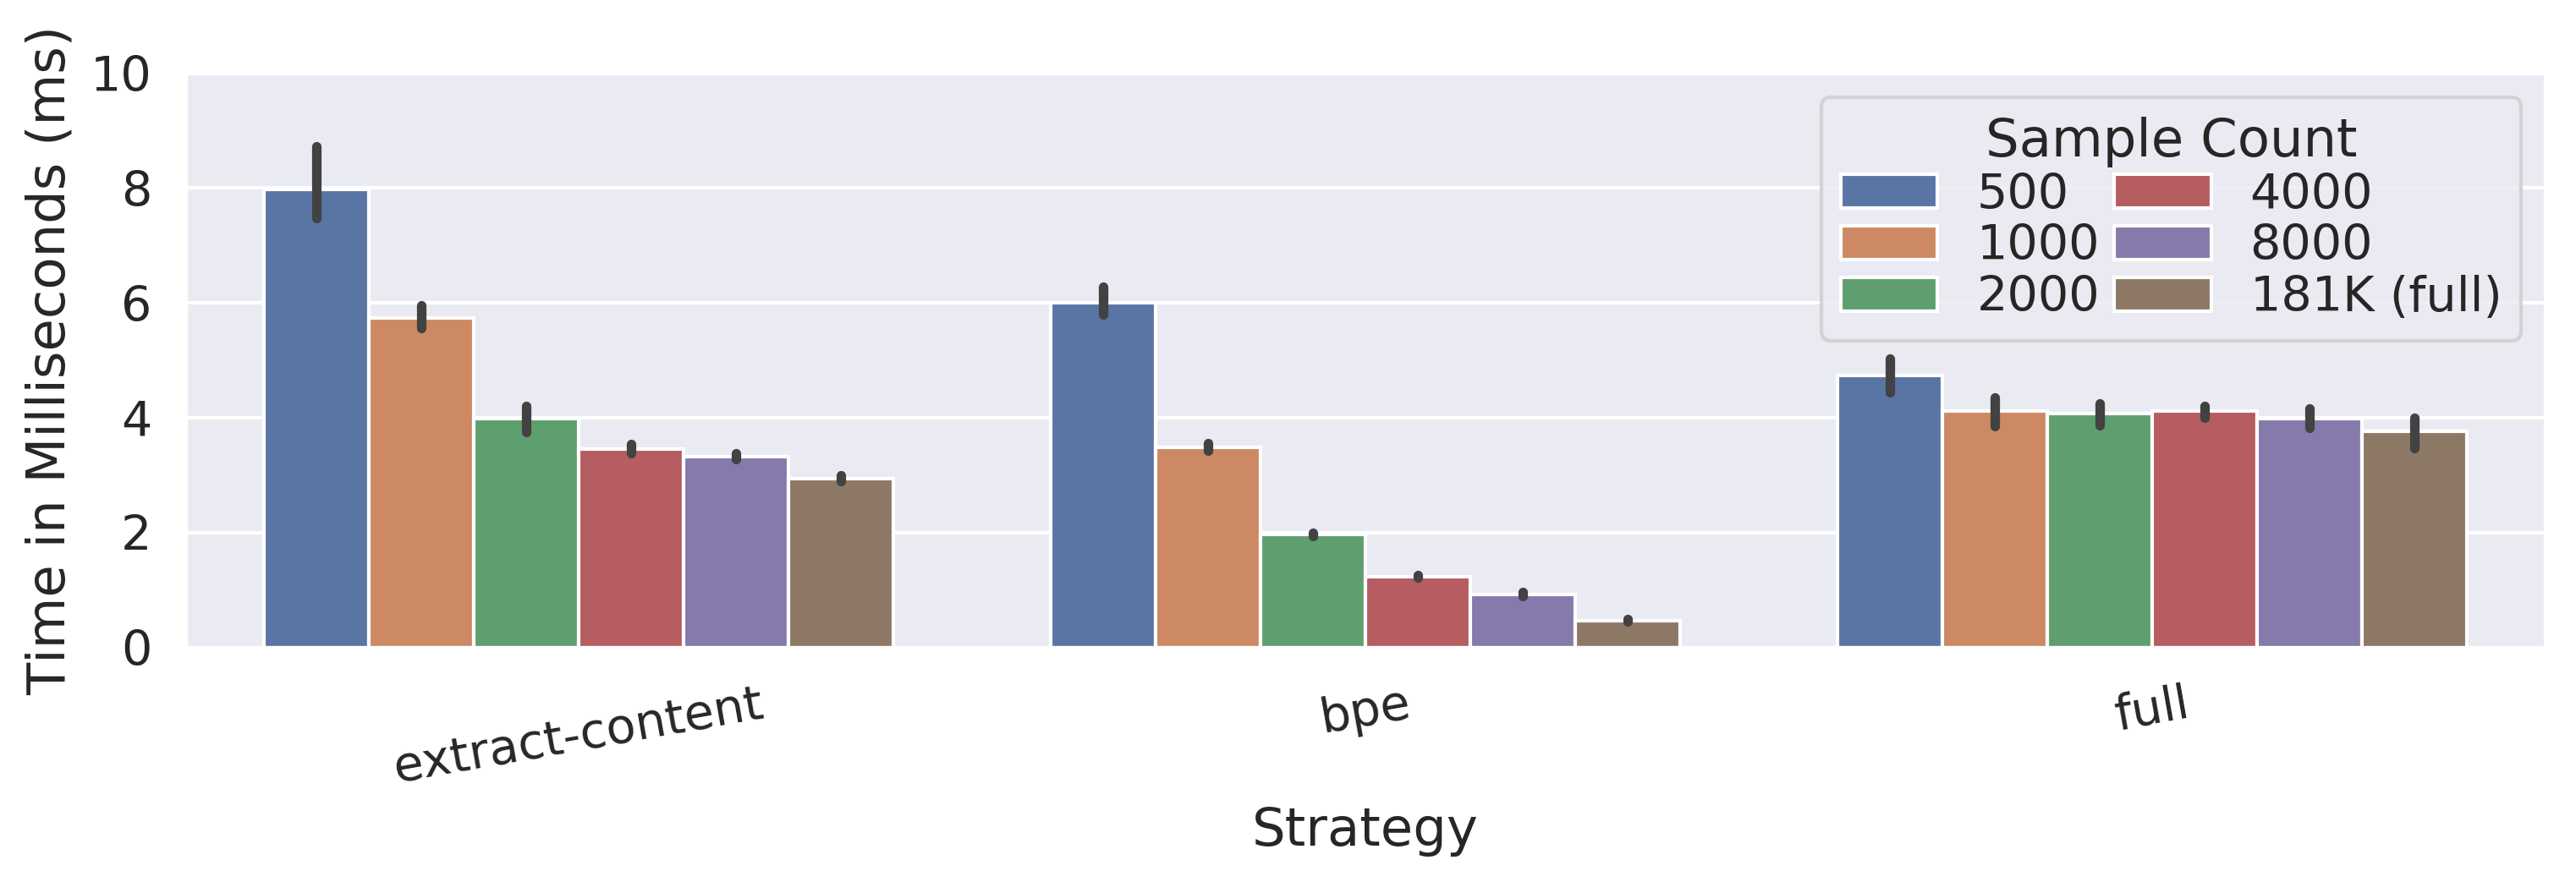

In [24]:
step_2 = '2-extract-content'
step_3 = '3-byte-pair-encoding'
step_4 = '4-lookup-embedding'

cum_df_mod["per_sample_online_processing_time_ms"] = cum_df_mod["per_sample_online_processing_time_s"] * 1000
cum_df_mod["sample_count"] = cum_df_mod.sample_count.astype('category')

plot = sns.barplot(
    x="split_name",
    y="per_sample_online_processing_time_ms",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8 and (split_name=='{step_2}' or split_name=='{step_3}' or split_name=='{step_4}')")
)

#  and sample_count!='181K (full)'
#plot.set_title(f"Extrapolated Full Dataset Processing Time\n for Each Strategy with 8 Threads {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed[2:6]
  , rotation=10
)
plot.figure.set_figheight(3)
plot.figure.set_figwidth(12)
plot.set(xlabel="Strategy", ylabel="Time in Milliseconds (ms)")
plot.set(ylim=(0, 10))
plot.legend(title="Sample Count", loc="upper right", ncol=2,labelspacing=0.10, columnspacing=0.3)
save_fig("nlp-lookup-differences-s2-s3-s4")

In [25]:
step_2 = '2-extract-content'
step_3 = '3-byte-pair-encoding'
step_4 = '4-lookup-embedding'
step_2_per_sample_online_time_ms_mean = cum_df_mod.query(f"thread_count==8 and split_name=='{step_2}' and sample_count=='181K (full)'")["per_sample_online_processing_time_ms"].mean()
step_3_per_sample_online_time_ms_mean = cum_df_mod.query(f"thread_count==8 and split_name=='{step_3}' and sample_count=='181K (full)'")["per_sample_online_processing_time_ms"].mean()
step_4_per_sample_online_time_ms_mean = cum_df_mod.query(f"thread_count==8 and split_name=='{step_4}' and sample_count=='181K (full)'")["per_sample_online_processing_time_ms"].mean()

print(f"Average online preprocessing time per sample in milliseconds (ms), entire dataset")
print(f"  Step {step_2}:    {np.round(step_2_per_sample_online_time_ms_mean, 2)}ms")
print(f"  Step {step_3}: {np.round(step_3_per_sample_online_time_ms_mean, 2)}ms")
print(f"  Step {step_4}:   {np.round(step_4_per_sample_online_time_ms_mean, 2)}ms")

Average online preprocessing time per sample in milliseconds (ms), entire dataset
  Step 2-extract-content:    2.94ms
  Step 3-byte-pair-encoding: 0.47ms
  Step 4-lookup-embedding:   3.77ms


# Warning - Creating the plots based on `dstat` logs can take several hours

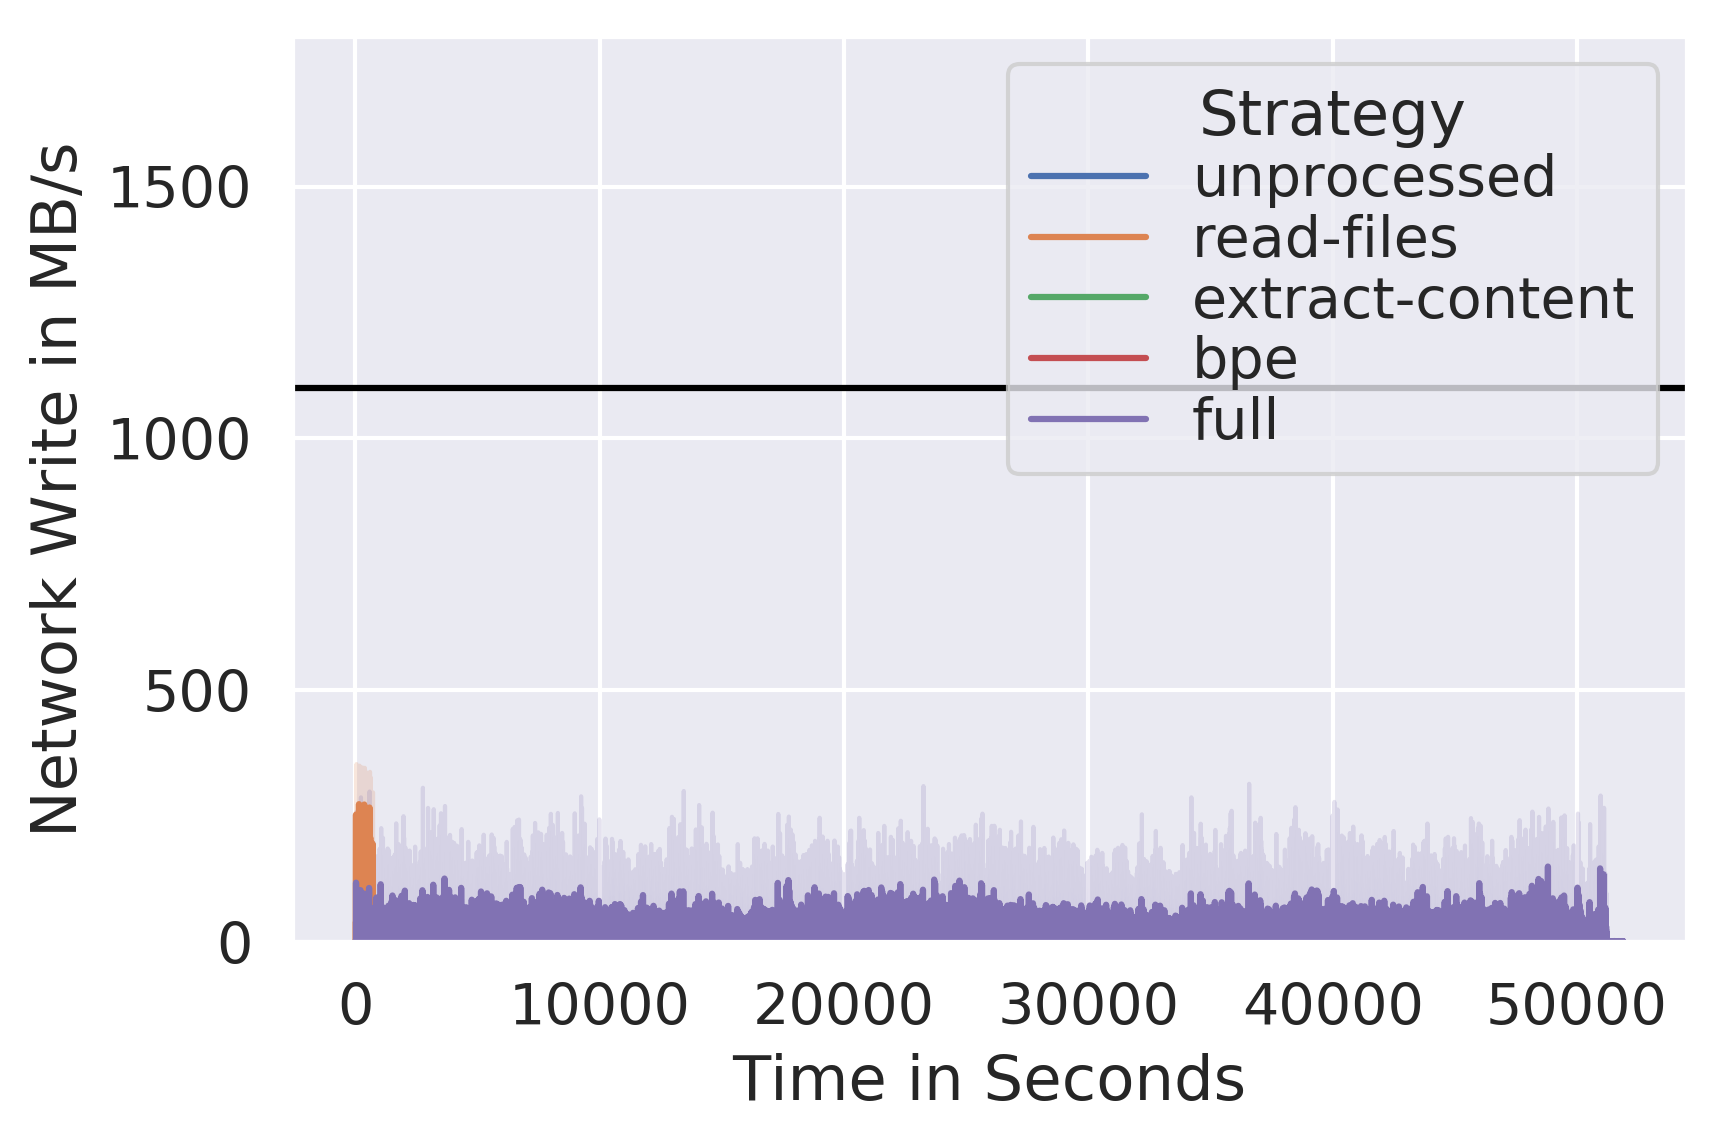

In [26]:
test_df = cum_dstat_df.query(f"sample_count=={full_dataset_textcount}").copy(deep=True)
test_df["sample_count"] = test_df.sample_count.astype('category')
test_df["split_name"] = test_df.split_name.astype('category')
test_df["thread_count"] = test_df.thread_count.astype('category')
plot = sns.lineplot(
    x="rel_time_s",
    y="net_write_mbs",
    hue="split_name",
    data=test_df.query("thread_count==8"),
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Write in MB/s")
plot.set(ylim=(0, 1800))
plot.axhline(1100, color="black")
plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
save_fig("network-write-speed-t8-full", file_type="png")

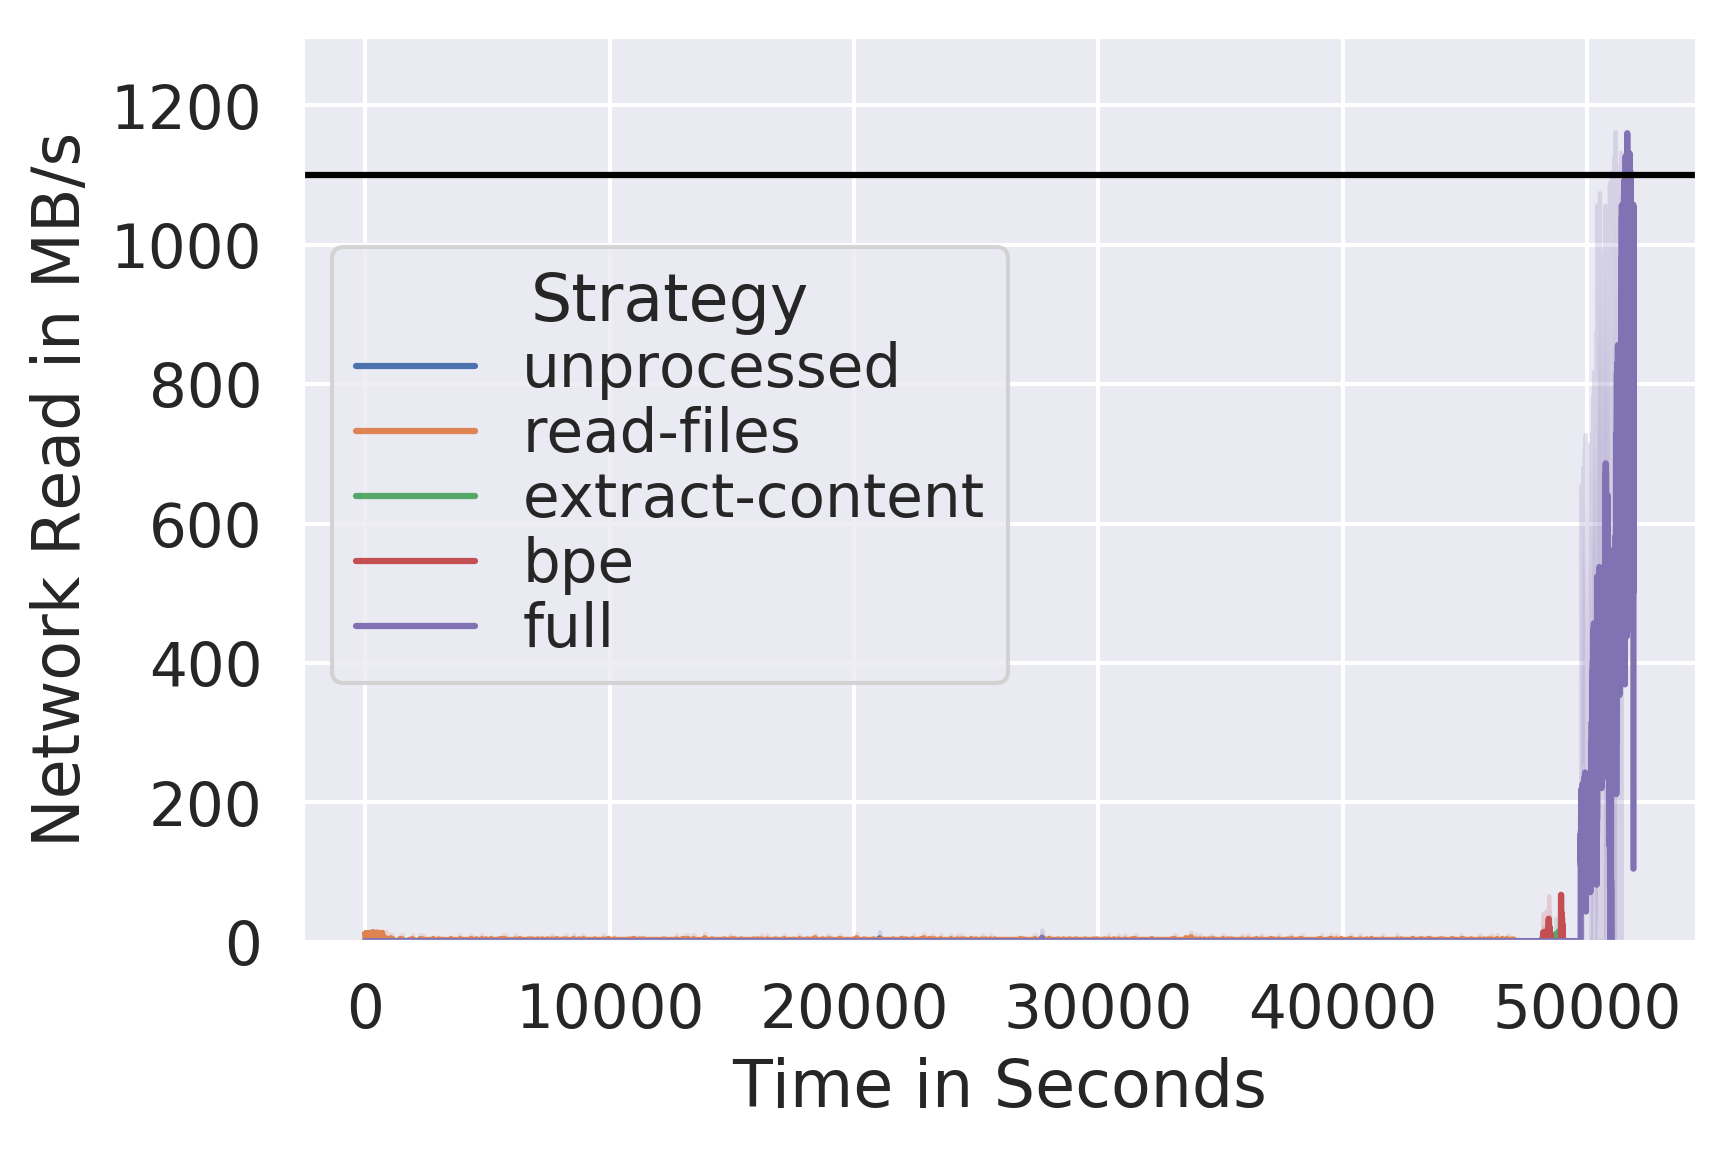

In [27]:
sns.set(font_scale=1.3)
test_df = cum_dstat_df.query(f"sample_count=={full_dataset_textcount}").copy(deep=True)
test_df["sample_count"] = test_df.sample_count.astype('category')
test_df["split_name"] = test_df.split_name.astype('category')
test_df["thread_count"] = test_df.thread_count.astype('category')
plot = sns.lineplot(
    x="rel_time_s",
    y="net_read_mbs",
    hue="split_name",
    data=test_df.query("thread_count==8"),
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")
plot.set(ylim=(0, 1300))
plot.axhline(1100, color="black")
plot.legend(strategies_renamed, title="Strategy", loc="upper left", bbox_to_anchor=(0,0.8), ncol=1,labelspacing=0.10)
save_fig("network-read-speed-t8-full", file_type="png")

In [28]:
step_2 = '2-extract-content'
step_3 = '3-byte-pair-encoding'
mean_throughput_step_2 = cum_df.query(f"split_name=='{step_2}' and sample_count=={np.max(cum_df.sample_count.unique())}")[["throughput_sps", "split_name"]].mean()[0]
mean_throughput_step_3 = cum_df.query(f"split_name=='{step_3}' and sample_count=={np.max(cum_df.sample_count.unique())}")[["throughput_sps", "split_name"]].mean()[0]
print("Average Throughput for the Full Dataset:")
print(f"   - {step_2}:     {np.round(mean_throughput_step_2, 2)}")
print(f"   - {step_3}: {np.round(mean_throughput_step_3, 2)}")
print(f"   - Increase: {np.round(mean_throughput_step_3 / mean_throughput_step_2, 2)}x")

Average Throughput for the Full Dataset:
   - 2-extract-content:     340.4
   - 3-byte-pair-encoding: 2121.46
   - Increase: 6.23x


In [29]:
step_1 = '1-read-files'
step_2 = '2-extract-content'
step_3 = '3-byte-pair-encoding'
mean_throughput_step_1 = cum_df.query(f"split_name=='{step_1}' and sample_count=={8000}")[["throughput_sps", "split_name"]].mean()[0]
mean_throughput_step_2 = cum_df.query(f"split_name=='{step_2}' and sample_count=={8000}")[["throughput_sps", "split_name"]].mean()[0]
mean_throughput_step_3 = cum_df.query(f"split_name=='{step_3}' and sample_count=={8000}")[["throughput_sps", "split_name"]].mean()[0]
print("Average Throughput for the Full Dataset:")
print(f"   - {step_1}:     {np.round(mean_throughput_step_1, 2)}")
print(f"   - {step_2}:     {np.round(mean_throughput_step_2, 2)}")
print(f"   - {step_3}: {np.round(mean_throughput_step_3, 2)}")
#print(f"   - Increase: {np.round(mean_throughput_step_3 / mean_throughput_step_2, 2)}x")

Average Throughput for the Full Dataset:
   - 1-read-files:     4.55
   - 2-extract-content:     237.24
   - 3-byte-pair-encoding: 998.57


In [6]:
threads = 8
sample_count = 180662
unprocessed = '0-fully-online'
concatenated = '1-read-files'

test_dstat_df = cum_dstat_df.query(f"thread_count=={threads} and \
                                     sample_count=={sample_count}")
unprocessed_dstat_df = test_dstat_df.query(f"split_name=='{unprocessed}'")

print("---------------------------------------")
print("-- Unprocessed Network Read in MB/s --")
print(unprocessed_dstat_df.describe()["net_read_mbs"])

# because we have multiple runs and they dont stop at the same second, we take the maximum run and cut from there
# to average the network read speed
max_offline_processing_time_s = cum_df.query(f"split_name=='{concatenated}' and \
                     thread_count=={threads} and \
                     sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()

print(max_offline_processing_time_s)

concatenated_dstat_df = test_dstat_df.query(f"split_name=='{concatenated}' and \
                                              rel_time_s>={max_offline_processing_time_s}")
print("---------------------------------------")
print("-- Concatenated Network Read in MB/s --")
print(concatenated_dstat_df.describe()["net_read_mbs"])

---------------------------------------
-- Unprocessed Network Read in MB/s --
count    238694.000000
mean          0.168616
std           0.187422
min           0.000000
25%           0.029202
50%           0.123718
75%           0.264990
max          23.978283
Name: net_read_mbs, dtype: float64
724.98944
---------------------------------------
-- Concatenated Network Read in MB/s --
count    239717.000000
mean          0.158921
std           1.161855
min           0.000000
25%           0.000060
50%           0.000120
75%           0.000339
max          25.265928
Name: net_read_mbs, dtype: float64
